# Imports, Functions, Data

## Imports

In [1]:
from datetime import datetime, date, timedelta
import numpy as np
import pandas as pd
import utm
import math
import matplotlib.cm as cmx
import matplotlib
import matplotlib.pyplot as plt
import geopy.distance
import scipy.interpolate
from scipy.interpolate import griddata
from scipy.stats import kde
from matplotlib.patches import Rectangle
from scipy.stats import spearmanr

/usr/local/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Functions

In [3]:
# Functions

# For stripping blank lines from text docs -----------------------------------------------------------
def nonblank_lines(f):
    for l in f:
        line = l.rstrip()
        if line:
            yield line

# Convert lonlat points to xy given some reference point ----------------------------------------------            
def LL2XY(lon,lat,dep,reflon,reflat):
    newxarray = []
    newyarray = []
    XYZ = []
    for i in range(len(lon)):
        if reflat <= lat[i]:
            newyarray.append(geopy.distance.geodesic([reflat,reflon], [lat[i],reflon]).km)
        else:
            newyarray.append(-(geopy.distance.geodesic([reflat,reflon], [lat[i],reflon]).km))
        if reflon <= lon[i]:
            newxarray.append(geopy.distance.geodesic([reflat,reflon], [reflat,lon[i]]).km)
        else:
            newxarray.append(-(geopy.distance.geodesic([reflat,reflon], [reflat,lon[i]]).km))
        XYZ.append([newxarray[i],newyarray[i],dep[i]])
    newzarray = dep
    return np.array(newxarray), np.array(newyarray), np.array(newzarray), np.array(XYZ)

# Find the near vertical plane that best fits a fault geometry -----------------------------------------
def get_nearvertplane (xx,yy,zz,plot):
    tmp_A = []
    tmp_b = []
    for i in range(len(xx)):
        tmp_A.append([xx[i], zz[i], 1])
        tmp_b.append(yy[i])
    b = np.matrix(tmp_b).T
    A = np.matrix(tmp_A)
    fit = (A.T * A).I * A.T * b
    errors = b - A * fit
    residual = np.linalg.norm(errors)    

    xlim = [min(xx)-1,max(xx)+1]
    zlim = [min(zz)-1,max(zz)+1]
    X,Z = np.meshgrid(np.arange(xlim[0], xlim[1]),
                      np.arange(zlim[0], zlim[1]))
    Y = np.zeros(X.shape)
    for r in range(X.shape[0]):
        for c in range(X.shape[1]):
            Y[r,c] = fit[0] * X[r,c] + fit[1] * Z[r,c] + fit[2]
    
    if plot == 1:
        fig = plt.figure(figsize = (12,8))
        ax = fig.add_subplot(1,3,1,projection='3d')
        ax.scatter(xx, yy, zz, color='g',alpha = 0.5)
        ax.plot_wireframe(X,Y,Z, color='k',alpha = 0.5)
        ax.scatter(0,0,0, c = 'r')
        ax.invert_zaxis()
        ax.view_init(0, 270)
        ax.set_xlabel('EW (km))',fontsize = 12)
        ax.set_ylabel('NS (km))',fontsize = 12)
        ax.set_zlabel('Depth (km)',fontsize = 12)
        ax = fig.add_subplot(1,3,2,projection='3d')
        ax.scatter(xx, yy, zz, color='g',alpha = 0.5)
        ax.plot_wireframe(X,Y,Z, color='k',alpha = 0.5)
        ax.scatter(0,0,0, c = 'r')
        ax.invert_zaxis()
        ax.view_init(45, 270)
        ax.set_xlabel('EW (km))',fontsize = 12)
        ax.set_ylabel('NS (km))',fontsize = 12)
        ax.set_zlabel('Depth (km)',fontsize = 12)
        ax = fig.add_subplot(1,3,3,projection='3d')
        ax.scatter(xx, yy, zz, color='g',alpha = 0.5)
        ax.plot_wireframe(X,Y,Z, color='k',alpha = 0.5)
        ax.scatter(0,0,0, c = 'r')
        ax.invert_zaxis()
        ax.view_init(90, 270)
        ax.set_xlabel('EW (km))',fontsize = 12)
        ax.set_ylabel('NS (km))',fontsize = 12)
        ax.set_zlabel('Depth (km)',fontsize = 12)
    else:
        pass
    
    print("approx. solution to: ax + by + cz = d")
    a = float(fit[0])
    b = float(-1)
    c = float(fit[1])
    d = float(-fit[2])
    print("a = %f, b = %f, c = %f, d = %f" % (a,b,c,d))
    normal = np.array([a,b,c])
    normal = normal/np.linalg.norm(normal)
    pop = [0,d/b,0] #a point on this plane (x = 0, z = 0, y = d/b)
    return a, b, c, d, normal, pop

# Project points orthagonally onto a specified plane --------------------------------------------------
def pointstoplane(points, norm, D, pop,plot):
    projectedpoints = []
    fromplanedistabs = []
    fromplanedist = []
    NEWCROSS = [] #along cross section
    NEWZ = [] #down cross section
    
    a = norm[0]
    b = norm[1]
    z0normvec = np.array([a,b])
    unitz0normvec = z0normvec/np.linalg.norm(z0normvec)
    xxxxx = []
    yyyyy = []
    for i in range(len(points)):
        
        temporaryv = points[i]-pop
        fromplanedistabs.append(abs(np.dot(temporaryv,norm)))
        fromplanedist.append(np.dot(temporaryv,norm))
        projectedpoints.append(points[i] - fromplanedist[i]*norm)
        
        temporaryv2 = (projectedpoints[i])[0:2]-pop[0:2]
        dist2 = np.dot(temporaryv2,unitz0normvec)
        
        xxxxx.append(((projectedpoints[i])[0]) - (dist2*unitz0normvec[0]))
        yyyyy.append((((projectedpoints[i])[1]) - (dist2*unitz0normvec[1]))+D)
        NEWCROSS.append(math.sqrt(xxxxx[i]**2+yyyyy[i]**2))
        NEWZ.append((projectedpoints[i])[2])
    
    if plot == 1:
        fig = plt.figure(figsize = (16,8))
        ax = fig.add_subplot(1,4,1,projection='3d')
        ax.scatter([i[0] for i in points], [i[1] for i in points], [i[2] for i in points], color='g',alpha = 0.5)
        ax.scatter([i[0] for i in projectedpoints], [i[1] for i in projectedpoints], [i[2] for i in projectedpoints], color='b',alpha = 0.5)
        ax.scatter(pop[0],pop[1],pop[2], c = 'r', s = 50,zorder = 3)
        ax.invert_zaxis()
        ax.view_init(45, 270)
        ax.set_xlabel('EW (km))',fontsize = 12)
        ax.set_ylabel('NS (km))',fontsize = 12)
        ax.set_zlabel('Depth (km)',fontsize = 12)
        ax = fig.add_subplot(1,4,2,projection='3d')
        ax.scatter([i[0] for i in points], [i[1] for i in points], [i[2] for i in points], color='g',alpha =0.5)
        ax.scatter([i[0] for i in projectedpoints], [i[1] for i in projectedpoints], [i[2] for i in projectedpoints], color='b',alpha = 0.5)
        ax.scatter(pop[0],pop[1],pop[2], c = 'r', s = 50,zorder = 3)
        ax.invert_zaxis()
        ax.view_init(90, 270)
        ax.set_xlabel('EW (km))',fontsize = 12)
        ax.set_ylabel('NS (km))',fontsize = 12)
        ax.set_zlabel('Depth (km)',fontsize = 12)
        ax = fig.add_subplot(1,4,3,projection='3d')
        ax = fig.add_subplot(1,4,4,aspect=1.0)
        ax.scatter(NEWCROSS,NEWZ, c='b')
        ax.set_aspect('equal')
        ax.invert_yaxis()
        ax = fig.add_subplot(1,4,3,aspect=1.0)
        ax.scatter(xxxxx,yyyyy, c='b')
        ax.scatter(0,0, c = 'r')
        ax.set_aspect('equal')
    else:
        pass
    return projectedpoints, NEWCROSS, NEWZ, fromplanedistabs

# Regrid and calculate gradient of slip data (already on a single plane) ---------------------------------------------

# note about regridding - regridding is most applicable when the resolution of the grids used are coarser than that of
# the original models. For one thing, it is not always made clear whether the point specified for each cell
# in the original models refers to the centre-centre, centre-top, top-left, top-right etc, thus effectively downsampling
# makes the regridded modelmore reliable (albeit at a coarser resolution).


# SINGLE NON OVERLAPPING SLIP MODEL (1 input)
def getnewgridandgrad(spacingx,spacingy,dataset):
    XSPACING = np.arange(spacingx[0],spacingx[1],spacingx[2])
    YSPACING = np.arange(spacingy[0],spacingy[1],spacingy[2])
    NEWDATA = griddata((dataset[0], dataset[1]), dataset[2], (XSPACING[None,:], YSPACING[:,None]), method='linear' , fill_value = 0)
    #NEWDATA is the new gridding 
    NEWDATATRANS = np.transpose(NEWDATA)
    #NEWDATATRANS is for grad analysis
    NEWDATASTACK = np.hstack(np.transpose(NEWDATA))
    #NEWDATASTACK is for the cc analysis
    gx, gy = np.gradient(NEWDATATRANS)
    GRAD = []
    for i in range(len(gy[0])):
        tempgrad = []
        for j in range(len(gy)):
            tempgrad.append(math.sqrt((((gx[j])[i])/spacingx[2])**2 + (((gy[j])[i])/spacingy[2])**2))   
        GRAD.append(tempgrad)
    return NEWDATA,NEWDATATRANS,NEWDATASTACK,GRAD

# Regrid and calculate gradient of slip data (already on a single plane) ---------------------------------------------
# TWO OVERLAPPING SLIP MODELS (2 inputs)
def getnewgridandgradFOROVERLAP(spacingx,spacingy,dataset1,dataset2): #give grid and dataset for new spacing and gradient
    XSPACING = np.arange(spacingx[0],spacingx[1],spacingx[2])
    YSPACING = np.arange(spacingy[0],spacingy[1],spacingy[2])
    NEWDATA1 = griddata((dataset1[0], dataset1[1]), dataset1[2], (XSPACING[None,:], YSPACING[:,None]), method='linear' , fill_value = 0)
    NEWDATA2 = griddata((dataset2[0], dataset2[1]), dataset2[2], (XSPACING[None,:], YSPACING[:,None]), method='linear' , fill_value = 0)
    NEWDATA = []
    for i in range(len(NEWDATA1)):
        temparray1 = []
        for j in range(len(NEWDATA1[i])):
            temparray1.append((NEWDATA1[i])[j]+(NEWDATA2[i])[j])
        NEWDATA.append(temparray1)
    #NEWDATA is the new gridding
    NEWDATATRANS = np.transpose(NEWDATA)
    #NEWDATATRANS is for grad analysis
    NEWDATASTACK = np.hstack(np.transpose(NEWDATA))
    #NEWDATASTACK is for the cc analysis
    gx, gy = np.gradient(NEWDATATRANS)
    GRAD = []
    for i in range(len(gy[0])):
        tempgrad = []
        for j in range(len(gy)):
            tempgrad.append(math.sqrt((((gx[j])[i])/spacingx[2])**2 + (((gy[j])[i])/spacingy[2])**2))   
        GRAD.append(tempgrad)
    return NEWDATA,NEWDATATRANS,NEWDATASTACK,GRAD

# Regrid and calculate gradient of slip data (already on a single plane) ---------------------------------------------
# THREE OVERLAPPING SLIP MODELS (3 inputs)
def getnewgridandgradFOROVERLAP3(spacingx,spacingy,dataset1,dataset2,dataset3): #give grid and dataset for new spacing and gradient
    XSPACING = np.arange(spacingx[0],spacingx[1],spacingx[2])
    YSPACING = np.arange(spacingy[0],spacingy[1],spacingy[2])
    NEWDATA1 = griddata((dataset1[0], dataset1[1]), dataset1[2], (XSPACING[None,:], YSPACING[:,None]), method='linear' , fill_value = 0)
    NEWDATA2 = griddata((dataset2[0], dataset2[1]), dataset2[2], (XSPACING[None,:], YSPACING[:,None]), method='linear' , fill_value = 0)
    NEWDATA3 = griddata((dataset3[0], dataset3[1]), dataset3[2], (XSPACING[None,:], YSPACING[:,None]), method='linear' , fill_value = 0)
    NEWDATA = []
    for i in range(len(NEWDATA1)):
        temparray1 = []
        for j in range(len(NEWDATA1[i])):
            temparray1.append((NEWDATA1[i])[j]+(NEWDATA2[i])[j]+(NEWDATA3[i])[j])
        NEWDATA.append(temparray1)

    #NEWDATA is the new gridding
    NEWDATATRANS = np.transpose(NEWDATA)
    #NEWDATATRANS is for grad analysis
    NEWDATASTACK = np.hstack(np.transpose(NEWDATA))
    #NEWDATASTACK is for the cc analysis

    gx, gy = np.gradient(NEWDATATRANS)
    GRAD = []
    for i in range(len(gy[0])):
        tempgrad = []
        for j in range(len(gy)):
            tempgrad.append(math.sqrt((((gx[j])[i])/spacingx[2])**2 + (((gy[j])[i])/spacingy[2])**2))   
        GRAD.append(tempgrad)
    return NEWDATA,NEWDATATRANS,NEWDATASTACK,GRAD

# Regrid and calculate gradient of slip data (already on a single plane) ---------------------------------------------
# FOUR OVERLAPPING SLIP MODELS (4 inputs)
def getnewgridandgradFOROVERLAP4(spacingx,spacingy,dataset1,dataset2,dataset3,dataset4): #give grid and dataset for new spacing and gradient
    XSPACING = np.arange(spacingx[0],spacingx[1],spacingx[2])
    YSPACING = np.arange(spacingy[0],spacingy[1],spacingy[2])
    NEWDATA1 = griddata((dataset1[0], dataset1[1]), dataset1[2], (XSPACING[None,:], YSPACING[:,None]), method='linear' , fill_value = 0)
    NEWDATA2 = griddata((dataset2[0], dataset2[1]), dataset2[2], (XSPACING[None,:], YSPACING[:,None]), method='linear' , fill_value = 0)
    NEWDATA3 = griddata((dataset3[0], dataset3[1]), dataset3[2], (XSPACING[None,:], YSPACING[:,None]), method='linear' , fill_value = 0)
    NEWDATA4 = griddata((dataset4[0], dataset4[1]), dataset4[2], (XSPACING[None,:], YSPACING[:,None]), method='linear' , fill_value = 0)
    NEWDATA = []
    for i in range(len(NEWDATA1)):
        temparray1 = []
        for j in range(len(NEWDATA1[i])):
            temparray1.append((NEWDATA1[i])[j]+(NEWDATA2[i])[j]+(NEWDATA3[i])[j]+(NEWDATA4[i])[j])
        NEWDATA.append(temparray1)

    #NEWDATA is the new gridding
    NEWDATATRANS = np.transpose(NEWDATA)
    #NEWDATATRANS is for grad analysis
    NEWDATASTACK = np.hstack(np.transpose(NEWDATA))
    #NEWDATASTACK is for the cc analysis

    gx, gy = np.gradient(NEWDATATRANS)
    GRAD = []
    for i in range(len(gy[0])):
        tempgrad = []
        for j in range(len(gy)):
            tempgrad.append(math.sqrt((((gx[j])[i])/spacingx[2])**2 + (((gy[j])[i])/spacingy[2])**2))   
        GRAD.append(tempgrad)
    return NEWDATA,NEWDATATRANS,NEWDATASTACK,GRAD

# Regrid aftershock data ------------------------------------------------------------------------------------------
def getnewgridSHOCKS(spacingx,spacingy,dataset): #give grid and dataset for new spacing and gradient
    k = kde.gaussian_kde(dataset)
    xi, yi = np.mgrid[spacingx[0]:spacingx[1]:spacingx[2], spacingy[0]:spacingy[1]:spacingy[2]]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    return xi,yi,zi

# Correlation calculating functions -------------------------------------------------------------------------
def correlationwithnozeros(dataset1,dataset2): # No (near-)zero values
    normdata2 = []
    for i in range(len(dataset2)):
        normdata2.append((dataset2[i]-min(dataset2))/(max(dataset2)-min(dataset2)))
    dataset1_ = []
    dataset2_ = []
    for i in range(len(dataset1)):
        if abs(dataset1[i]) < 0.001 and abs(normdata2[i]) < 0.001:
            pass
        else:
            dataset1_.append(dataset1[i])
            dataset2_.append(dataset2[i])
    return spearmanr(dataset1_,dataset2_)

def correlationwithnozeros1(dataset1,dataset2): # No values less than 10% of dataset1 maximum value
    A = 0.1*max(dataset1)
    normdata2 = []
    for i in range(len(dataset2)):
        normdata2.append((dataset2[i]-min(dataset2))/(max(dataset2)-min(dataset2)))
    dataset1_ = []
    dataset2_ = []
    for i in range(len(dataset1)):
        if abs(dataset1[i]) < A: #and abs(normdata2[i]) < B:
            pass
        else:
            dataset1_.append(dataset1[i])
            dataset2_.append(dataset2[i])
    return spearmanr(dataset1_,dataset2_)

## Event Data

In [7]:
EVENTNAMES = ['Parkfield', 'Napa', 'Ridgecrest', 'El Mayor Cucapah', 'Izmit', 'Van', 'L\'Aquila']
EVENTMAGS = [6.0,6.0,7.1,7.2,7.6,7.1,6.3,6.3]
EVENTTIMES = [datetime(2004,9,28,17,15,24),datetime(2014,8,24,10,20,44),datetime(2019,7,6,3,19,53),datetime(2010,4,4,22,40,42),datetime(1999,8,17,0,1,39),datetime(2011,10,23,10,41,23),datetime(2009,4,6,1,32,39)]
EVENTLONS = [-120.366,-122.312,-117.599,-115.295,29.9952,43.508,13.3561]
EVENTLATS = [35.818,38.215,35.770,32.286,40.7968,38.721,42.3583]

## Seismic Data

In [16]:
PQ = pd.read_csv('./catalogs/PQ.csv')
PQ['times'] = PQ['times'].astype('datetime64[ns]')
NQ = pd.read_csv('./catalogs/NQ.csv')
NQ['times'] = NQ['times'].astype('datetime64[ns]')
RQ = pd.read_csv('./catalogs/RQ.csv')
RQ['times'] = RQ['times'].astype('datetime64[ns]')
EQ = pd.read_csv('./catalogs/EQ.csv')
EQ['times'] = EQ['times'].astype('datetime64[ns]')
IQ = pd.read_csv('./catalogs/IQ.csv')
IQ['times'] = IQ['times'].astype('datetime64[ns]')
VQ = pd.read_csv('./catalogs/VQ.csv')
VQ['times'] = VQ['times'].astype('datetime64[ns]')
LQ = pd.read_csv('./catalogs/LQ.csv')
LQ['times'] = LQ['times'].astype('datetime64[ns]')

## Coseismic Slip and Afterslip Models 

### Parkfield
+ Coseismic slip and Afterslip model by Jiang et al., (2021)

In [4]:
# CO + AFT

#The 2 fault geometries
parksegs1 = pd.read_csv('./SlipModels/PARK_JIANG/4_FaultGeometry/geometry_SWFZ_lonlat.csv')
parksegs2 = pd.read_csv('./SlipModels/PARK_JIANG/4_FaultGeometry/geometry_SAF_lonlat.csv')

# Model timesteps (in seconds, and as datetimes - previously extracted from model names)
parktimes_inseconds = [90, 180, 205, 240, 290, 360, 459, 600, 799, 1080, 1478, 2040, 2835, 3960, 5551, 7800, 10981, 15480, 21842, 30840, 43565, 61560, 87009, 123000, 173899, 245880, 347677, 491640, 695234, 983160, 1390349, 1966200, 2780577, 3932280, 5561034, 7864440, 11121948, 15728760, 22243776, 31457400, 44487432, 62914680, 88974744, 125829240, 177949368]
parktimesteps = [datetime(2004, 9, 28, 17, 16, 54), datetime(2004, 9, 28, 17, 18, 24), datetime(2004, 9, 28, 17, 18, 49), datetime(2004, 9, 28, 17, 19, 24), datetime(2004, 9, 28, 17, 20, 14), datetime(2004, 9, 28, 17, 21, 24), datetime(2004, 9, 28, 17, 23, 3), datetime(2004, 9, 28, 17, 25, 24), datetime(2004, 9, 28, 17, 28, 43), datetime(2004, 9, 28, 17, 33, 24), datetime(2004, 9, 28, 17, 40, 2), datetime(2004, 9, 28, 17, 49, 24), datetime(2004, 9, 28, 18, 2, 39), datetime(2004, 9, 28, 18, 21, 24), datetime(2004, 9, 28, 18, 47, 55), datetime(2004, 9, 28, 19, 25, 24), datetime(2004, 9, 28, 20, 18, 25), datetime(2004, 9, 28, 21, 33, 24), datetime(2004, 9, 28, 23, 19, 26), datetime(2004, 9, 29, 1, 49, 24), datetime(2004, 9, 29, 5, 21, 29), datetime(2004, 9, 29, 10, 21, 24), datetime(2004, 9, 29, 17, 25, 33), datetime(2004, 9, 30, 3, 25, 24), datetime(2004, 9, 30, 17, 33, 43), datetime(2004, 10, 1, 13, 33, 24), datetime(2004, 10, 2, 17, 50, 1), datetime(2004, 10, 4, 9, 49, 24), datetime(2004, 10, 6, 18, 22, 38), datetime(2004, 10, 10, 2, 21, 24), datetime(2004, 10, 14, 19, 27, 53), datetime(2004, 10, 21, 11, 25, 24), datetime(2004, 10, 30, 21, 38, 21), datetime(2004, 11, 13, 5, 33, 24), datetime(2004, 12, 2, 1, 59, 18), datetime(2004, 12, 28, 17, 49, 24), datetime(2005, 2, 4, 10, 41, 12), datetime(2005, 3, 29, 18, 21, 24), datetime(2005, 6, 13, 4, 5), datetime(2005, 9, 27, 19, 25, 24), datetime(2006, 2, 25, 14, 52, 36), datetime(2006, 9, 26, 21, 33, 24), datetime(2007, 7, 25, 12, 27, 48), datetime(2008, 9, 24, 1, 49, 24), datetime(2010, 5, 20, 7, 38, 12)]

# (the coseismic slip model is loaded at index 0)

# Get slip model names and calculate max slip matrices
parkslip = []
parknames = []
for i in range(45):
    dataframename = str('park')+ str(int(parktimes_inseconds[i]))
    parknames.append(dataframename)
    globals()[dataframename] = pd.read_table('./SlipModels/PARK_JIANG/5_SlipModels/slip_model_step' + str(int(i)) +'.txt', names = ['Dss','Dds','Ess','Eds'], sep='\s+', skiprows=2)        
    jiangtottemp = []
    for i in range(len((globals()[dataframename])['Dss'])):
        Dss = ((globals()[dataframename])['Dss'])[i]
        Dds = ((globals()[dataframename])['Dds'])[i]
        jiangtottemp.append(math.sqrt(Dss**2 + Dds**2)/1000)
    parkslip.append((jiangtottemp))
    del globals()[dataframename]
del Dds, Dss, i, jiangtottemp


### South Napa
+ Coseismic slip and Afterslip model by Floyd et al., (2016)

In [5]:
# CO + AFT

# Segments
napasegs = pd.read_csv('./SlipModels/NAPA_FLOYD/grl54636-sup-0003-2016gl069428-ts02.csv')
# Raw slip data
napaslipdata = pd.read_csv('./SlipModels/NAPA_FLOYD/grl54636-sup-0004-2016gl069428-ts03.csv')

# Model timesteps (in seconds, and as datetimes - previously extracted from model names)
napatimestext = ['0','1','2','3','4','5','6','7','19','31','43','55','67']
napatimes_indays = [0,1,2,3,4,5,6,7,19,31,43,55,67]
napatimesteps = [datetime(2014, 8, 24, 10, 20, 44), datetime(2014, 8, 25, 10, 20, 44), datetime(2014, 8, 26, 10, 20, 44), datetime(2014, 8, 27, 10, 20, 44), datetime(2014, 8, 28, 10, 20, 44), datetime(2014, 8, 29, 10, 20, 44), datetime(2014, 8, 30, 10, 20, 44), datetime(2014, 8, 31, 10, 20, 44), datetime(2014, 9, 12, 10, 20, 44), datetime(2014, 9, 24, 10, 20, 44), datetime(2014, 10, 6, 10, 20, 44), datetime(2014, 10, 18, 10, 20, 44), datetime(2014, 10, 30, 10, 20, 44)]
napasegsno = np.array(napaslipdata['Segment'])

napaco = [] # array for the coseismic slip data
for i in range(len(napaslipdata['co1'])):
    napaco.append(math.sqrt((((napaslipdata['co1'])[i])**2)+(((napaslipdata['co2'])[i])**2)))

# slip data (coseismic slip model at index 0)    
noncum_napaslip = [napaco,napaslipdata['post0-1'],napaslipdata['post1-2'],napaslipdata['post2-3'],napaslipdata['post3-4'],napaslipdata['post4-5'],napaslipdata['post5-6'],napaslipdata['post6-7'],napaslipdata['post7-19'],napaslipdata['post19-31'],napaslipdata['post31-43'],napaslipdata['post43-55'],napaslipdata['post55-67']]
 
#calculate cumulative afterslip arrays for each timestep
napaslip = []
for i in range(len(napatimesteps)):
    if i == 0:
        tempcumpost = noncum_napaslip[i]
        napaslip.append(tempcumpost)
    elif i == 1:
        tempcumpost = noncum_napaslip[i]
        napaslip.append(tempcumpost)
    else:
        tempcumpost = tempcumpost+noncum_napaslip[i]
        napaslip.append(tempcumpost)
        
# conversion of spatial coordinates
napalon = []
napalat = []
napadep = []
napaareas = []                    
for i in range(7):
    midx = ((napasegs['UTM (Zone 10) easting'])[i])*1000
    midy = ((napasegs['UTM (Zone 10) northing'])[i])*1000
    length = ((napasegs['Length'])[i])*1000
    strike = math.radians((napasegs['Strike'])[i])
    dip = math.radians((napasegs['Dip'])[i])
    Nx = (napasegs['Nx'])[i]
    Nz = 20
    if (napasegs['Dip'])[i] == 86:
        width = 10.024*1000
        ntsd = 0.6993*1000 #normal to strike distance
    elif (napasegs['Dip'])[i] == 84:
        width = 10.055*1000
        ntsd = 1.051*1000
    else:
        pass
    alongstrikespacing = (length/Nx)
    napaareas.append(alongstrikespacing*(width/Nz))
    #The four corners
    startx = midx-(0.5*length)*math.sin(strike)
    starty = midy-(0.5*length)*math.cos(strike)
    endx = midx+(0.5*length)*math.sin(strike)
    endy = midy+(0.5*length)*math.cos(strike)
    bstartx = startx+(ntsd*math.sin(strike+math.pi/2))
    bstarty = starty+(ntsd*math.cos(strike+math.pi/2))
    bendx = endx+(ntsd*math.sin(strike+math.pi/2))
    bendy = endy+(ntsd*math.cos(strike+math.pi/2))
    for j in range(Nx):
        for k in range(Nz):
            if j == 0 and k == 0:
                x = endx
                y = endy
                z = 0
            else:
                x = endx - ((length*j/Nx)*math.sin(strike) +(ntsd*(k/20)*math.sin(strike+math.pi/2)))
                y = endy - ((length*j/Nx)*math.cos(strike) +(ntsd*(k/20)*math.sin(strike+math.pi/2)))
                z = 10000*(k/20)
            aa, bb = utm.to_latlon(x,y,10,northern = True)
            napalon.append(bb)
            napalat.append(aa)
            napadep.append(z/1000)

napaXSEC = []
napaXDEP = []
for i in range(len(napaslipdata)):
    tempx = ((napaslipdata['X'])[i])
    tempz = ((napaslipdata['Z'])[i])
    if (napaslipdata['Segment'])[i] == 1:
        napaXSEC.append((tempx))
        napaXDEP.append((tempz))
    elif (napaslipdata['Segment'])[i] == 2: 
        napaXSEC.append(12+(tempx))
        napaXDEP.append((tempz))
    elif (napaslipdata['Segment'])[i] == 3:
        napaXSEC.append(17+(tempx))
        napaXDEP.append((tempz))
    elif (napaslipdata['Segment'])[i] == 4:
        napaXSEC.append(18+(tempx))
        napaXDEP.append((tempz))  
    elif (napaslipdata['Segment'])[i] == 5: 
        napaXSEC.append(24+(tempx))
        napaXDEP.append((tempz))
    elif (napaslipdata['Segment'])[i] == 6:
        napaXSEC.append(27+(tempx))
        napaXDEP.append((tempz))
    elif (napaslipdata['Segment'])[i] == 7:
        napaXSEC.append(56+(tempx))
        napaXDEP.append((tempz))

### Ridgecrest
+ Coseismic slip and Afterslip model by Yue et al., (2021)



In [8]:
# CO + AFT

#the coseismic slip model
yueridgeco = pd.read_csv('./SlipModels/RIDGE_YUE/comodel.csv')
yueridgeslipco = yueridgeco['slip(m)']
yueridgemomsco = yueridgeco['Mo(Nm)']
yueridgelonco = yueridgeco['lon']
yueridgelatco = yueridgeco['lat']
yueridgedepco = yueridgeco['depth']

#the afterslip model with foreshock model removed
yueridge = pd.read_csv('./SlipModels/RIDGE_YUE/modelwithoutfore.csv')
yueridgeslip = yueridge['slip(m)']
yueridgemoms = yueridge['Mo(Nm)']
yueridgelon = yueridge['lon']
yueridgelat = yueridge['lat']
yueridgedep = yueridge['depth']
yueridgesegsnums = yueridge['segnum']
yueridgetimestep = EVENTTIMES[2] + timedelta(days = 150)




### El Mayor Cucapah
+ Afterslip model by Rollins et al., (2015), Coseismic slip model (from SRCMOD) by Wei et al., (2011)

The original afterslip model files supplied by Chris Rollins are in x-y-z format, in UTM zone 11 with a centre of 35.5, -115.5. The 3 files are the 3 fault segments, and x1, x2, x3 refers to the North-East-Down coordinates of the top left corner of each cell


In [9]:
# AFT
emc1 = pd.read_csv('./SlipModels/EMC_ROLLINS/rollins1.csv', index_col = 0)
emc2 = pd.read_csv('./SlipModels/EMC_ROLLINS/rollins2.csv', index_col = 0)
emc3 = pd.read_csv('./SlipModels/EMC_ROLLINS/rollins3.csv', index_col = 0)
emctimestep = EVENTTIMES[3] + timedelta(days = 1096)

emcslip = np.concatenate((emc1['slip'],emc2['slip'],emc3['slip']))
emcdep = np.concatenate((emc1['x3'],emc2['x3'],emc3['x3']))

# Coordinate conversion
RXC = utm.from_latlon(32.5,-115.5)[0]
RYC = utm.from_latlon(32.5,-115.5)[1]
rollinsxpoints = []
rollinsypoints = []
for i in range(len(emc1)):
    rollinsypoints.append(((emc1['x1'])[i])*1000+RYC)
    rollinsxpoints.append(((emc1['x2'])[i])*1000+RXC)
for i in range(len(emc2)):
    rollinsypoints.append(((emc2['x1'])[i])*1000+RYC)
    rollinsxpoints.append(((emc2['x2'])[i])*1000+RXC)
for i in range(len(emc3)):
    rollinsypoints.append(((emc3['x1'])[i])*1000+RYC)
    rollinsxpoints.append(((emc3['x2'])[i])*1000+RXC)
emclat, emclon = utm.to_latlon(np.array(rollinsxpoints), np.array(rollinsypoints), 11, northern = True)

# CO
myfile = open('./SlipModels/EMC_ROLLINS/s2010ELMAYO01WEIx.fsp')
emclonco = []; emclatco = []; emcdepco = []; emcslipco = []
for line in nonblank_lines(myfile):
    if not line.startswith("%"):
        line = line.split()
        emclatco.append(float(line[0])); emclonco.append(float(line[1])); emcdepco.append(float(line[4])); emcslipco.append(float(line[5]))  
            

### Izmit
+ Afterslip model by Burgmann et al., (2002), Coseismic sip model (from SRCMOD) by Reilinger et al., (2000)

In [10]:
#AFT

izmitsegs = pd.read_csv('./SlipModels/IZMIT_BURGMANN/FAULTGEOM.csv')
izmitlons = []
izmitlats = []
izmitdeps = []
for i in range(len(izmitsegs['wid'])):
    templondiff = ((izmitsegs['endlon'])[i] - (izmitsegs['startlon'])[i])/7
    templatdiff = ((izmitsegs['endlat'])[i] - (izmitsegs['startlat'])[i])/7
    tempdepdiff = 50/12
    for j in range(7):
        for k in range(12):
            izmitlons.append(((izmitsegs['startlon'])[i])+(templondiff*j))
            izmitlats.append(((izmitsegs['startlat'])[i])+(templatdiff*j))
            izmitdeps.append(0+(tempdepdiff*k))
izmittimes = np.linspace(1,87,87)
izmittimesteps = []
for i in range(len(izmittimes)):
    izmittimesteps.append(EVENTTIMES[4] + timedelta(days = izmittimes[i]))
    
izmitdata = pd.read_csv('./SlipModels/IZMIT_BURGMANN/data.csv', header = None)
izmitslip = []
for i in range(0,87):
    izmitslip.append(abs(izmitdata[i]/100))

# CO
myfile = open('./SlipModels/IZMIT_BURGMANN/s1999IZMITT01REIL.fsp')
izlonco = []; izlatco = []; izdepco = []; izslipco = []
for line in nonblank_lines(myfile):
    if not line.startswith("%"):
        line = line.split()
        izlatco.append(float(line[0])); izlonco.append(float(line[1])); izdepco.append(float(line[4])); izslipco.append(float(line[5]))

### Van
+ Afterslip model by Trasatti et al., (2016), Coseismic slip model (from SRCMOD) by Elliott et al., (2013)

In [11]:
# AFT
vandata1 = pd.read_csv('./SlipModels/VAN_TRASATTI/4d.csv')
vandata2 = pd.read_csv('./SlipModels/VAN_TRASATTI/17d.csv')

vanlat, vanlon = utm.to_latlon(np.array(vandata1['x']), np.array(vandata1['y']), 38, northern = True)
vandep = vandata1['z']/-1000
vanslip = [vandata1['slip']/100,vandata2['slip']/100]
vantimes = [4,17]
vantimesteps = []
for i in range(len(vantimes)):
    vantimesteps.append(EVENTTIMES[5] + timedelta(days = vantimes[i]))
    
# CO           
myfile = open('./SlipModels/VAN_TRASATTI/s2011VANTUR01ELLI.fsp')
vanlonco = []; vanlatco = []; vandepco = []; vanslipco = []
for line in nonblank_lines(myfile):
    if not line.startswith("%"):
        line = line.split()
        vanlatco.append(float(line[0])); vanlonco.append(float(line[1])); vandepco.append(float(line[4])); vanslipco.append(float(line[5]))   

### L\'Aquila
+ Afterslip model by D'Agostino et al., (2012), Coseismic slip model by Gallovic et al., (2015)
    
The original afterslip model files supplied by Daniele Cheloni and Nicola D'Agostino were provided with the following column information: 1-2-3) longitude (deg), latitude (deg) and depth (km) of the center of the top of the fault patch; 4-5) fault patch dimensions (km), length and width; 6-7) dip and strike (degrees); 8-9) components of slip, U1 and U2 (in mm); rake is fixed at -100°; ignore the other columns.

In [12]:
# AFT
LAQNAMES = []
laqslip = []

for i in range(1,10):
    TEMPSLIP = []
    tempname ='LAQ'+str(int(i-1))
    LAQNAMES.append(tempname)
    globals()[tempname] = pd.read_csv('./SlipModels/LAQUILA_DAGOSTINO/JGR_2012_solutions/solution_T0' + str(int(i)) +'_S09.out', sep="\s+",header = None,names = ['lon','lat','dep','len','wid','dip','str','s1','s2','ingore','ignore2','ignore3','ignore4','igniore5']) 
    for j in range(len((globals()[tempname]['s1']))):
        TEMPSLIP.append(((((globals()[tempname]['s1'])[j]**2)+((globals()[tempname]['s1'])[j]**2))**0.5)/100)
    laqslip.append(TEMPSLIP)
for i in range(10,32):
    TEMPSLIP = []
    tempname ='LAQ'+str(int(i-1))
    LAQNAMES.append(tempname)
    globals()[tempname] = pd.read_csv('./SlipModels/LAQUILA_DAGOSTINO/JGR_2012_solutions/solution_T' + str(int(i)) +'_S09.out', sep="\s+",header = None,names = ['lon','lat','dep','len','wid','dip','str','s1','s2','ingore','ignore2','ignore3','ignore4','igniore5'])  
    for j in range(len((globals()[tempname]['s1']))):
        TEMPSLIP.append(((((globals()[tempname]['s1'])[j]**2)+((globals()[tempname]['s1'])[j]**2))**0.5)/100)
    laqslip.append(TEMPSLIP)
    
laqtimes = [1,8,17,24,32,48,49,56,64,65,72,81,88,96,97,104,112,113,120,128,129,136,144,145,152,160,161,168,176,177,184]
laqtimesteps = []
for i in range(len(laqtimes)):
    laqtimesteps.append(EVENTTIMES[6] + timedelta(days = laqtimes[i]))

laqlon = LAQ0['lon']
laqlat = LAQ0['lat']
laqdep = LAQ0['dep']

# CO
myfile = open('./SlipModels/LAQUILA_DAGOSTINO/s2009LAQUIL01GALL.fsp')
laqlonco = []; laqlatco = []; laqdepco = []; laqslipco = []
for line in nonblank_lines(myfile):
    if not line.startswith("%"):
        line = line.split()
        laqlatco.append(float(line[0])); laqlonco.append(float(line[1])); laqdepco.append(float(line[4])); laqslipco.append(float(line[5]))
    


# Projections and Analysis

## Initial Set-up

In [13]:
### Set preliminary reference points (somewhere along strike beyond fault)
DEPREF = 0
PLONREF, PLATREF = np.min(parksegs2['lon'])-0.05,np.max(parksegs2['lat'])+0.05
NLONREF, NLATREF = np.min(napalon)-0.05,np.max(napalat)+0.03
RLONREF, RLATREF = np.min(yueridgelon)-0.1,np.max(yueridgelat)+0.1
ELONREF, ELATREF = np.min(emclon)-0.1,np.max(emclat)+0.1
ILONREF, ILATREF = np.min(izmitlons)-0.1,np.max(izmitlats)+0.1
VLONREF, VLATREF = np.min(vanlonco)-0.1,np.min(vanlatco)-0.05
LLONREF, LLATREF = np.min(laqlon)-0.1,np.max(laqlat)+0.1

In [14]:
# CONVERT PLANES TO COORDINATE SYSTEM
PX1, PY1, PZ1, PXYZ1 = LL2XY(parksegs1['lon'],parksegs1['lat'],parksegs1['Dep[km]'],PLONREF,PLATREF)
PX2, PY2, PZ2, PXYZ2 = LL2XY(parksegs2['lon'],parksegs2['lat'],parksegs2['Dep[km]'],PLONREF,PLATREF)
NX1, NY1, NZ1, NXYZ1 = LL2XY(napalon,napalat,napadep,NLONREF,NLATREF)
RX1, RY1, RZ1, RXYZ1 = LL2XY(yueridgelon, yueridgelat,yueridgedep,RLONREF,RLATREF)
RCOX1, RCOY1, RCOZ1, RCOXYZ1 = LL2XY(yueridgelonco,yueridgelatco,yueridgedepco,RLONREF,RLATREF)
EX1, EY1, EZ1, EXYZ1 = LL2XY(emclon,emclat,emcdep,ELONREF,ELATREF)
ECOX1, ECOY1, ECOZ1, ECOXYZ1 = LL2XY(emclonco,emclatco,emcdepco,ELONREF,ELATREF)
IX1, IY1, IZ1, IXYZ1 = LL2XY(izmitlons,izmitlats,izmitdeps,ILONREF,ILATREF)
ICOX1, ICOY1, ICOZ1, ICOXYZ1 = LL2XY(izlonco,izlatco,izdepco,ILONREF,ILATREF)
VX1, VY1, VZ1, VXYZ1 = LL2XY(vanlon,vanlat,vandep,VLONREF,VLATREF)
VCOX1, VCOY1, VCOZ1, VCOXYZ1 = LL2XY(vanlonco,vanlatco,vandepco,VLONREF,VLATREF)
LX1, LY1, LZ1, LXYZ1 = LL2XY(laqlon,laqlat,laqdep,LLONREF,LLATREF)
LCOX1, LCOY1, LCOZ1, LCOXYZ1 = LL2XY(laqlonco,laqlatco,laqdepco,LLONREF,LLATREF)

In [17]:
# CONVERT SHOCKS TO COORDINATE SYSTEM (TAKES A WHILE...)
PQ['XXX'], PQ['YYY'],PQ['ZZZ'], PQPOINTS = LL2XY(PQ['longitude'],PQ['latitude'],PQ['depth'],PLONREF,PLATREF)
NQ['XXX'], NQ['YYY'], NQ['ZZZ'], NQPOINTS = LL2XY(NQ['longitude'],NQ['latitude'],NQ['depth'],NLONREF,NLATREF)
RQ['XXX'], RQ['YYY'], RQ['ZZZ'], RQPOINTS = LL2XY(RQ['longitude'],RQ['latitude'],RQ['depth'],RLONREF,RLATREF)
EQ['XXX'], EQ['YYY'], EQ['ZZZ'], EQPOINTS = LL2XY(EQ['longitude'],EQ['latitude'],EQ['depth'],ELONREF,ELATREF)
IQ['XXX'], IQ['YYY'], IQ['ZZZ'], IQPOINTS = LL2XY(IQ['lon'],IQ['lat'],IQ['dep'],ILONREF,ILATREF)
VQ['XXX'], VQ['YYY'], VQ['ZZZ'], VQPOINTS = LL2XY(VQ['lon'],VQ['lat'],VQ['dep'],VLONREF,VLATREF)
LQ['XXX'], LQ['YYY'], LQ['ZZZ'], LQPOINTS = LL2XY(LQ['lon'],LQ['lat'],LQ['dep'],LLONREF,LLATREF)

## Finding and Projecting onto Best Fitting Planes

/var/folders/ss/3c6ht1_957qfcmkn0qbrk5nx74dht3/T/ipykernel_4607/2852013917.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y[r,c] = fit[0] * X[r,c] + fit[1] * Z[r,c] + fit[2]
/var/folders/ss/3c6ht1_957qfcmkn0qbrk5nx74dht3/T/ipykernel_4607/2852013917.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a = float(fit[0])
/var/folders/ss/3c6ht1_957qfcmkn0qbrk5nx74dht3/T/ipykernel_4607/2852013917.py:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c = float(fit[1

approx. solution to: ax + by + cz = d
a = -1.204687, b = -1.000000, c = -0.042051, d = -1.094318
approx. solution to: ax + by + cz = d
a = -2.086546, b = -1.000000, c = -0.219543, d = -3.104265
approx. solution to: ax + by + cz = d
a = -1.080151, b = -1.000000, c = 0.031036, d = 2.900865
approx. solution to: ax + by + cz = d
a = -1.115585, b = -1.000000, c = 0.823708, d = -0.021293
approx. solution to: ax + by + cz = d
a = 0.018001, b = -1.000000, c = -0.000000, d = 17.384532
approx. solution to: ax + by + cz = d
a = 0.140621, b = -1.000000, c = 0.847518, d = -6.248327
approx. solution to: ax + by + cz = d
a = -1.183877, b = -1.000000, c = -1.443670, d = -9.094381

Plots show:
 + The reference point (red),
 + The original geometry (green),
 + The best fitting plane (black).


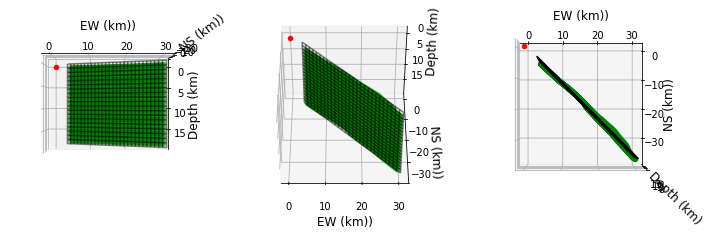

In [18]:
# Best fitting planes
# (setting the 4th input in this function to 1 plots it, manually check outputs are sensible)
PA, PB, PC, PD, PNORM, PPOP = get_nearvertplane (PX2,PY2,PZ2,1) #The SAF (not SWFZ) plane used
NA, NB, NC, ND, NNORM, NPOP = get_nearvertplane (NX1,NY1,NZ1,0)
RA, RB, RC, RD, RNORM, RPOP = get_nearvertplane (RX1,RY1,RZ1,0)
EA, EB, EC, ED, ENORM, EPOP = get_nearvertplane (EX1,EY1,EZ1,0) 
IA, IB, IC, ID, INORM, IPOP = get_nearvertplane (IX1,IY1,IZ1,0)
VA, VB, VC, VD, VNORM, VPOP = get_nearvertplane (VX1,VY1,VZ1,0)
LA, LB, LC, LD, LNORM, LPOP = get_nearvertplane (LX1,LY1,LZ1,0)

print('\nPlots show:\n + The reference point (red),\n + The original geometry (green),\n + The best fitting plane (black).')


Plots show:
 + The reference point (red),
 + The original geometry (green),
 + Projection onto the best fitting plane (blue).


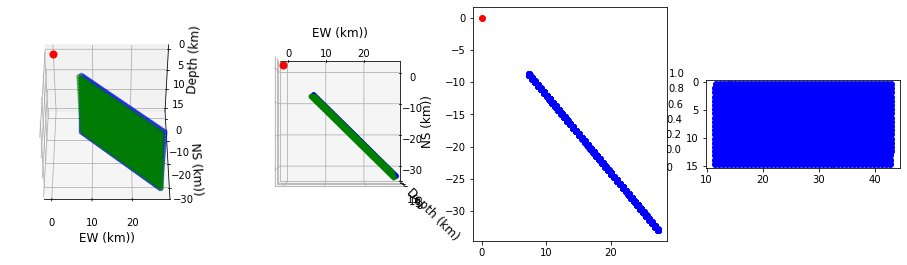

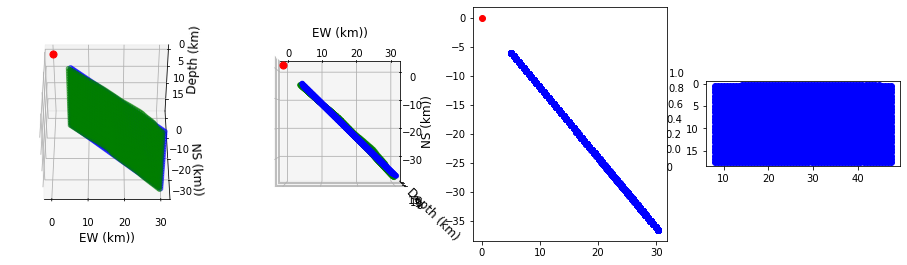

In [19]:
# Projecting fault geom points onto best fitting plane

# (setting the 4th input in this function to 1 plots it, manually check outputs are sensible)
# PARK JIANG SWFZ (CO+AFT)
PARKFIELDPROJ1, PSLIPCROSSX1, PSLIPCROSSZ1, PDISTS1 = pointstoplane(PXYZ1,PNORM,PD,PPOP,1)
# PARK JIANG SAF (AFT)
PARKFIELDPROJ2, PSLIPCROSSX2, PSLIPCROSSZ2, PDISTS2 = pointstoplane(PXYZ2,PNORM,PD,PPOP,1)
# NAPA FLOYD (CO+AFT)
NAPAPROJ1, NSLIPCROSSX1, NSLIPCROSSZ1, NDISTS1 = pointstoplane(NXYZ1,NNORM,ND,NPOP,0)
# RIDGE YUE (AFT)
RIDGEPROJ1, RSLIPCROSSX1, RSLIPCROSSZ1, RDISTS1 = pointstoplane(RXYZ1,RNORM,RD,RPOP,0) 
# RIDGE YUE (CO PLANES)
RIDGEPROJ3, RSLIPCROSSX3, RSLIPCROSSZ3, RDISTS3 = pointstoplane(RCOXYZ1,RNORM,RD,RPOP,0)
# EMC ROLLINS (AFT)
EMCPROJ1, ESLIPCROSSX1, ESLIPCROSSZ1,EDISTS1 = pointstoplane(EXYZ1,ENORM,ED,EPOP,0)
# EMC WEI (CO)
EMCPROJ2, ESLIPCROSSX2, ESLIPCROSSZ2,EDISTS2 = pointstoplane(ECOXYZ1,ENORM,ED,EPOP,0)
# IZMIT BURGMANN (AFT)
IZMITPROJ1, ISLIPCROSSX1, ISLIPCROSSZ1,IDISTS1 = pointstoplane(IXYZ1,INORM,ID,IPOP,0)
# IZMIT REILINGER (CO)
IZMITPROJ2, ISLIPCROSSX2, ISLIPCROSSZ2,IDISTS2 = pointstoplane(ICOXYZ1,INORM,ID,IPOP,0)
# VAN TRASATTI (AFT)
VANPROJ1, VSLIPCROSSX1, VSLIPCROSSZ1,VDISTS1 = pointstoplane(VXYZ1,VNORM,VD,VPOP,0)
# VAN ELLIOTT (CO)
VANPROJ2, VSLIPCROSSX2, VSLIPCROSSZ2,VDISTS2 = pointstoplane(VCOXYZ1,VNORM,VD,VPOP,0)
# LAQUILA DAGOSTINO (AFT)
LAQPROJ1, LSLIPCROSSX1, LSLIPCROSSZ1,LDISTS1 = pointstoplane(LXYZ1,LNORM,LD,LPOP,0)
# LAQUILA GALLOVIC (CO)
LAQPROJ2, LSLIPCROSSX2, LSLIPCROSSZ2,LDISTS2 = pointstoplane(LCOXYZ1,LNORM,LD,LPOP,0)
print('\nPlots show:\n + The reference point (red),\n + The original geometry (green),\n + Projection onto the best fitting plane (blue).')


In [20]:
#Projecting aftershocks onto best fitting plane (and then sort...)
PSHOCKS, PSHOCKSCROSSX, PSHOCKSCROSSZ, PDIST = pointstoplane(PQPOINTS,PNORM,PD,PPOP,0)
NSHOCKS, NSHOCKSCROSSX, NSHOCKSCROSSZ, NDIST = pointstoplane(NQPOINTS,NNORM,ND,NPOP,0)
RSHOCKS, RSHOCKSCROSSX, RSHOCKSCROSSZ, RDIST = pointstoplane(RQPOINTS,RNORM,RD,RPOP,0)
ESHOCKS, ESHOCKSCROSSX, ESHOCKSCROSSZ, EDIST = pointstoplane(EQPOINTS,ENORM,ED,EPOP,0)
ISHOCKS, ISHOCKSCROSSX, ISHOCKSCROSSZ, IDIST = pointstoplane(IQPOINTS,INORM,ID,IPOP,0)
VSHOCKS, VSHOCKSCROSSX, VSHOCKSCROSSZ, VDIST = pointstoplane(VQPOINTS,VNORM,VD,VPOP,0)
LSHOCKS, LSHOCKSCROSSX, LSHOCKSCROSSZ, LDIST = pointstoplane(LQPOINTS,LNORM,LD,LPOP,0)

PQ['DIST'], PQ['SHOCKSCROSSX'], PQ['SHOCKSCROSSZ'] = PDIST, PSHOCKSCROSSX, PSHOCKSCROSSZ
NQ['DIST'], NQ['SHOCKSCROSSX'], NQ['SHOCKSCROSSZ'] = NDIST, NSHOCKSCROSSX, NSHOCKSCROSSZ
RQ['DIST'], RQ['SHOCKSCROSSX'], RQ['SHOCKSCROSSZ'] = RDIST, RSHOCKSCROSSX, RSHOCKSCROSSZ
EQ['DIST'], EQ['SHOCKSCROSSX'], EQ['SHOCKSCROSSZ'] = EDIST, ESHOCKSCROSSX, ESHOCKSCROSSZ
IQ['DIST'], IQ['SHOCKSCROSSX'], IQ['SHOCKSCROSSZ'] = IDIST, ISHOCKSCROSSX, ISHOCKSCROSSZ
VQ['DIST'], VQ['SHOCKSCROSSX'], VQ['SHOCKSCROSSZ'] = VDIST, VSHOCKSCROSSX, VSHOCKSCROSSZ
LQ['DIST'], LQ['SHOCKSCROSSX'], LQ['SHOCKSCROSSZ'] = LDIST, LSHOCKSCROSSX, LSHOCKSCROSSZ

# filter shocks by min magnitude, distance from plane, and correct quadrant (relative to reference point)
# This is the +/- quadrant in all cases, except Van, which is +/+ (just a function of where the reference piunt is)
PQo = PQ[(PQ['mag'] >= 1.5) & (PQ['DIST'] <= 2.5) & (PQ['XXX'] >= 0) & (PQ['YYY'] <= 0)]
NQo = NQ[(NQ['mag'] >= 1.5) & (NQ['DIST'] <= 2.5) & (NQ['XXX'] >= 0) & (NQ['YYY'] <= 0)]
RQo = RQ[(RQ['mag'] >= 2.2) & (RQ['DIST'] <= 5) & (RQ['XXX'] >= 0) & (RQ['YYY'] <= 0)]
EQo = EQ[(EQ['mag'] >= 2.2) & (EQ['DIST'] <= 5) & (EQ['XXX'] >= 0) & (EQ['YYY'] <= 0)]
IQo = IQ[(IQ['mag'] >= 2.7) & (IQ['DIST'] <= 5) & (IQ['XXX'] >= 0) & (IQ['YYY'] <= 0)]
VQo = VQ[(VQ['mag'] >= 2.7) & (VQ['DIST'] <= 5) & (VQ['XXX'] >= 0) & (VQ['YYY'] >= 0)]
LQo = LQ[(LQ['mag'] >= 2.7) & (LQ['DIST'] <= 5) & (LQ['XXX'] >= 0) & (LQ['YYY'] <= 0)]


## Example Regridding/Gradient Figures 

/var/folders/ss/3c6ht1_957qfcmkn0qbrk5nx74dht3/T/ipykernel_4607/2852013917.py:265: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde(dataset)
/var/folders/ss/3c6ht1_957qfcmkn0qbrk5nx74dht3/T/ipykernel_4607/3312985476.py:130: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(shrink = 0.8, location = 'bottom')


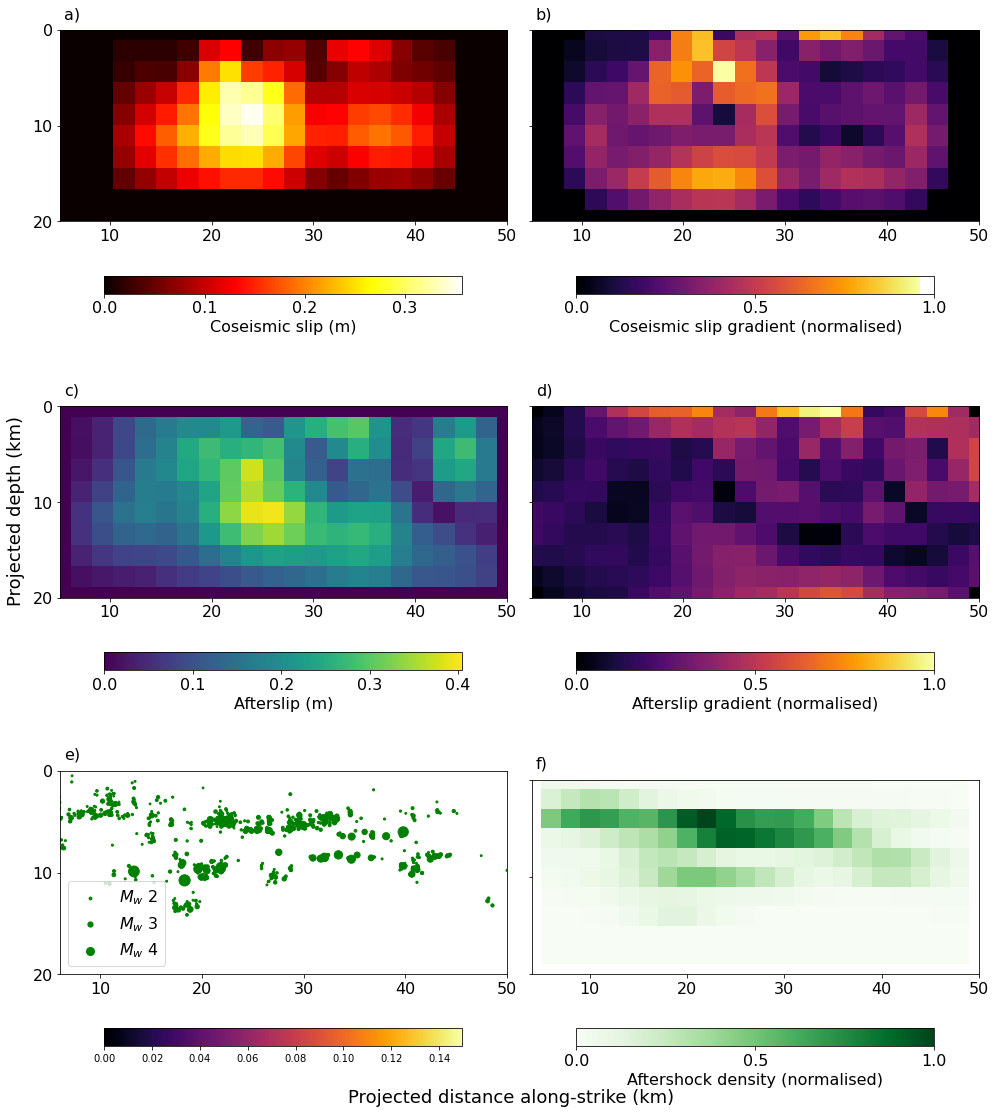

In [21]:
#PARKFIGURE

#import matplotlib.patches as patches

TIME = EVENTTIMES[0] + timedelta(days=500)
PQooo = PQ[(PQ['mag'] >= 1.5) & (PQ['DIST'] <= 2.5) & (PQ['XXX'] >= 0) & (PQ['YYY'] <= 0) & (PQ['times'] < TIME)]
      
PARKX = [6,50,2]
PARKY = [0,20,2]
PARKCO = [PSLIPCROSSX1, PSLIPCROSSZ1,parkslip[0]]
PARKAFT = [PSLIPCROSSX2, PSLIPCROSSZ2,parkslip[32]]
PARKSHOCKS = (PQooo['SHOCKSCROSSX'],PQooo['SHOCKSCROSSZ'])
PARKDATA, PARKDATATRANS, PARKDATASTACK, PARKGRAD = getnewgridandgrad(PARKX,PARKY,PARKCO)
PARKSDATA, PARKSDATATRANS, PARKSDATASTACK, PARKSGRAD = getnewgridandgrad(PARKX,PARKY,PARKAFT)
PARKXI, PARKYI, PARKSHOCKS =getnewgridSHOCKS(PARKX,PARKY,PARKSHOCKS)
TOPLOTPARKX = np.arange(PARKX[0],PARKX[1],PARKX[2])
TOPLOTPARKY = np.arange(PARKY[0],PARKY[1],PARKY[2])

fig = plt.figure(figsize = (20,16))

cm = plt.get_cmap('hot')
Norm = matplotlib.colors.Normalize(vmin=0, vmax=max(parkslip[0]))
scalarMap = cmx.ScalarMappable(norm=Norm, cmap=cm)

ax = fig.add_subplot(3,3,1)
plt.imshow(PARKDATA,cmap = cm, norm = Norm)
cb = plt.colorbar(shrink = 0.8,location = 'bottom')
cb.set_label('Coseismic slip (m)',fontsize = 16)
cb.set_ticks([0,0.1,0.2,0.3],fontsize = 16)
cb.set_ticklabels(['0.0','0.1','0.2','0.3'],fontsize = 16)
ax.set_ylim([0,len(PARKDATA)-1])
ax.set_xlim([0,len(PARKDATA[0])-1])
ax.set_yticks([0,(len(PARKDATA)-1)/2,len(PARKDATA)-1])
ax.set_yticklabels(['0','10','20'],fontsize = 16)
ax.set_xticks([(7/46)*len(PARKDATA[0])-1,(17/46)*len(PARKDATA[0])-1,(27/46)*len(PARKDATA[0])-1,(37/46)*len(PARKDATA[0])-1,len(PARKDATA[0])-1])
ax.set_xticklabels(['10','20','30','40','50'],fontsize = 16)
ax.text(0.01,1.12, 'a)',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes, fontsize = 16)
ax.set_aspect('equal')
ax.invert_yaxis()

maxgrad = 0
for i in range(len(PARKGRAD)):
    if max(PARKGRAD[i]) > maxgrad:
        maxgrad = max(PARKGRAD[i])
    else:
        pass

cm = plt.get_cmap('inferno')
Norm = matplotlib.colors.Normalize(vmin=0, vmax=maxgrad)
scalarMap = cmx.ScalarMappable(norm=Norm, cmap=cm)

ax = fig.add_subplot(3,3,2)
plt.imshow(PARKGRAD,cmap = cm, norm = Norm)
cb = plt.colorbar(shrink = 0.8, location = 'bottom')
cb.set_label('Coseismic slip gradient (normalised)',fontsize = 16)
cb.set_ticks([0,0.04,0.08])
cb.set_ticklabels(['0.0','0.5','1.0'],fontsize = 16)
ax.set_ylim([0,len(PARKDATA)-1])
ax.set_xlim([0,len(PARKDATA[0])-1])
ax.set_yticks([0,(len(PARKDATA)-1)/2,len(PARKDATA)-1])
ax.set_yticklabels(['','',''])
ax.set_xticks([(7/46)*len(PARKDATA[0])-1,(17/46)*len(PARKDATA[0])-1,(27/46)*len(PARKDATA[0])-1,(37/46)*len(PARKDATA[0])-1,len(PARKDATA[0])-1])
ax.set_xticklabels(['10','20','30','40','50'],fontsize = 16)
ax.text(0.01,1.12, 'b)',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes, fontsize = 16)
ax.set_aspect('equal')
ax.invert_yaxis()

cm = plt.get_cmap('viridis')
Norm = matplotlib.colors.Normalize(vmin=0, vmax=max(parkslip[32]))
scalarMap = cmx.ScalarMappable(norm=Norm, cmap=cm)


ax = fig.add_subplot(3,3,4)
plt.imshow(PARKSDATA,cmap = cm, norm = Norm)
cb = plt.colorbar(shrink = 0.8, location = 'bottom')
cb.set_label('Afterslip (m)',fontsize = 16)
cb.set_ticks([0,0.1,0.2,0.3,0.4])
cb.set_ticklabels(['0.0','0.1','0.2','0.3','0.4'], fontsize = 16)
ax.set_ylim([0,len(PARKDATA)-1])
ax.set_xlim([0,len(PARKDATA[0])-1])
ax.set_yticks([0,(len(PARKDATA)-1)/2,len(PARKDATA)-1])
ax.set_yticklabels(['0','10','20'],fontsize = 16)
ax.set_xticks([(7/46)*len(PARKDATA[0])-1,(17/46)*len(PARKDATA[0])-1,(27/46)*len(PARKDATA[0])-1,(37/46)*len(PARKDATA[0])-1,len(PARKDATA[0])-1])
ax.set_xticklabels(['10','20','30','40','50'],fontsize = 16)
ax.text(0.01,1.12, 'c)',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes, fontsize = 16)
ax.set_aspect('equal')
ax.invert_yaxis()

maxgrad = 0
for i in range(len(PARKSGRAD)):
    if max(PARKSGRAD[i]) > maxgrad:
        maxgrad = max(PARKSGRAD[i])
    else:
        pass

cm = plt.get_cmap('inferno')
Norm = matplotlib.colors.Normalize(vmin=0, vmax=maxgrad)
scalarMap = cmx.ScalarMappable(norm=Norm, cmap=cm)

ax = fig.add_subplot(3,3,5)
plt.imshow(PARKSGRAD,cmap = cm, norm = Norm)
cb = plt.colorbar(shrink = 0.8, location = 'bottom')
cb.set_label('Afterslip gradient (normalised)',fontsize = 16)
cb.set_ticks([0,0.075,0.15])
cb.set_ticklabels(['0.0','0.5','1.0'], fontsize = 16)
ax.set_ylim([0,len(PARKDATA)-1])
ax.set_xlim([0,len(PARKDATA[0])-1])
ax.set_yticks([0,(len(PARKDATA)-1)/2,len(PARKDATA)-1])
ax.set_yticklabels(['','',''])
ax.set_xticks([(7/46)*len(PARKDATA[0])-1,(17/46)*len(PARKDATA[0])-1,(27/46)*len(PARKDATA[0])-1,(37/46)*len(PARKDATA[0])-1,len(PARKDATA[0])-1])
ax.set_xticklabels(['10','20','30','40','50'],fontsize = 16)
ax.text(0.01,1.12, 'd)',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes, fontsize = 16)
ax.set_aspect('equal')
ax.invert_yaxis()

ax = fig.add_subplot(3,3,7)
ax.scatter(PQooo['SHOCKSCROSSX'],PQooo['SHOCKSCROSSZ'],s = PQooo['mag']**3,c = 'g', zorder = 2)
cb = plt.colorbar(shrink = 0.8, location = 'bottom')
ax.scatter([],[],s=2**3, color = 'g', label = '$M_w$ 2')
ax.scatter([],[],s=3**3, color = 'g', label = '$M_w$ 3')
ax.scatter([],[],s=4**3, color = 'g', label = '$M_w$ 4')
ax.legend(fontsize = 16)
ax.set_ylim([0,20])
ax.set_xlim([6,50])
ax.set_yticks([0,10,20])
ax.set_yticklabels(['0','10','20'], fontsize = 16)
ax.set_xticks([10,20,30,40,50])
ax.set_xticklabels(['10','20','30','40','50'],fontsize = 16)
ax.text(0.01,1.12, 'e)',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes, fontsize = 16)
ax.set_aspect('equal')
ax.invert_yaxis()

cm = plt.get_cmap('Greens')
Norm = matplotlib.colors.Normalize(vmin=0, vmax=0.007380557332592937)

ax = fig.add_subplot(3,3,8)
a = ax.pcolormesh(PARKXI, PARKYI, PARKSHOCKS.reshape(PARKXI.shape), shading='auto', alpha = 1, cmap=cm, norm = Norm)
ax.set_ylim([0,20])
ax.set_xlim([4,50])
ax.set_yticks([0,10,20])
ax.set_yticklabels(['','',''])
ax.set_xticks([10,20,30,40,50])
ax.set_xticklabels(['10','20','30','40','50'], fontsize = 16)
cb = plt.colorbar(a, cmap = cm, norm = Norm, shrink = 0.8, location = 'bottom')
cb.set_label('Aftershock density (normalised)',fontsize = 16)
cb.set_ticks([0,0.007380557332592937/2,0.007380557332592937])
cb.set_ticklabels(['0.0','0.5','1.0'],fontsize = 16)
ax.set_aspect('equal')
ax.text(0.01,1.12, 'f)',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes, fontsize = 16)
ax.invert_yaxis()
fig.text(0.34, 0.01, 'Projected distance along-strike (km)',fontsize = 18, ha='center', va='center')
fig.text(-0.01, 0.52, 'Projected depth (km)',fontsize = 18, ha='left', va='center',rotation = 90)
plt.tight_layout()              

# Analysis and Plots

## Grids, Pre-calculations, and Parameters

In [22]:
# Grids, Pre-calculations, and Parameters

# Parkfield
PARKX = [0,55,2]
PARKY = [0,20,2]
parktempco = parkslip[0]
parktempaft = parkslip[32]
parktimes = []
PARKCO = [PSLIPCROSSX1, PSLIPCROSSZ1,parktempco] # CO + EARLY AFT
PARKAFT = [PSLIPCROSSX2, PSLIPCROSSZ2,parktempaft] # LATER AFT
PARKSHOCKS = (PQo['SHOCKSCROSSX'],PQo['SHOCKSCROSSZ']) # AFTERSHOCKS (PARK)
PARKXI, PARKYI, PARKSHOCKS =getnewgridSHOCKS(PARKX,PARKY,PARKSHOCKS)
TOPLOTPARKX = np.arange(PARKX[0],PARKX[1],PARKX[2])
TOPLOTPARKY = np.arange(PARKY[0],PARKY[1],PARKY[2])
PARKDATA, PARKDATATRANS, PARKDATASTACK, PARKGRAD = getnewgridandgrad(PARKX,PARKY,PARKCO)
PARKSDATA, PARKSDATATRANS, PARKSDATASTACK, PARKSGRAD = getnewgridandgrad(PARKX,PARKY,PARKAFT)

# South Napa
NAPAX = [0,40,2]
NAPAY = [0,12,2]
napatempco = napaslip[0]
napatempaft = napaslip[3]
napatimes = []
NAPACO1 = [[],[],[]] # THE MAINFAULT
NAPACO2 = [[],[],[]] # THE OVERLAPPERS (add these two)
NAPAAFT1 = [[],[],[]] # THE MAINFAULT
NAPAAFT2 = [[],[],[]] # THE OVERLAPPERS (add these two)
for i in range(len(napasegsno)):
    if napasegsno[i] == 1 or napasegsno[i] == 7:
        NAPACO2[0].append(NSLIPCROSSX1[i])
        NAPACO2[1].append(NSLIPCROSSZ1[i])
        NAPACO2[2].append(napatempco[i])
        NAPAAFT2[0].append(NSLIPCROSSX1[i])
        NAPAAFT2[1].append(NSLIPCROSSZ1[i])
        NAPAAFT2[2].append(napatempaft[i])
    else:
        NAPACO1[0].append(NSLIPCROSSX1[i])
        NAPACO1[1].append(NSLIPCROSSZ1[i])
        NAPACO1[2].append(napatempco[i])
        NAPAAFT1[0].append(NSLIPCROSSX1[i])
        NAPAAFT1[1].append(NSLIPCROSSZ1[i])
        NAPAAFT1[2].append(napatempaft[i])         
NAPADATA, NAPADATATRANS, NAPADATASTACK, NAPAGRAD = getnewgridandgradFOROVERLAP(NAPAX,NAPAY,NAPACO1,NAPACO2)
NAPASDATA, NAPASDATATRANS, NAPASDATASTACK, NAPASGRAD = getnewgridandgradFOROVERLAP(NAPAX,NAPAY,NAPAAFT1,NAPAAFT2)
NAPASHOCKS = (NQo['SHOCKSCROSSX'],NQo['SHOCKSCROSSZ']) # AFTERSHOCKS (NAPA)
NAPAXI, NAPAYI, NAPASHOCKS =getnewgridSHOCKS(NAPAX,NAPAY,NAPASHOCKS)
TOPLOTNAPAX = np.arange(NAPAX[0],NAPAX[1],NAPAX[2])
TOPLOTNAPAY = np.arange(NAPAY[0],NAPAY[1],NAPAY[2])

# Ridgecrest
RIDGEX = [0,100,2]
RIDGEY = [0,33,2]
ridgetempco = yueridgeslipco
ridgetempaft = yueridgeslip
ridgetimes = []
RIDGECO = [RSLIPCROSSX3, RSLIPCROSSZ3,ridgetempco] # CO
RIDGEAFT1 = [[],[],[]] # THE MAINFAULT
RIDGEAFT2 = [[],[],[]] # THE OVERLAPPERS (add these two) # AFT
for i in range(len(yueridgesegsnums)):
    if yueridgesegsnums[i] == 2 or yueridgesegsnums[i] == 3 or yueridgesegsnums[i] == 5 or yueridgesegsnums[i] == 6:
        RIDGEAFT2[0].append(RSLIPCROSSX1[i])
        RIDGEAFT2[1].append(RSLIPCROSSZ1[i])
        RIDGEAFT2[2].append(ridgetempaft[i])
    else:
        RIDGEAFT1[0].append(RSLIPCROSSX1[i])
        RIDGEAFT1[1].append(RSLIPCROSSZ1[i])
        RIDGEAFT1[2].append(ridgetempaft[i])         
RIDGEDATA, RIDGEDATATRANS, RIDGEDATASTACK, RIDGEGRAD = getnewgridandgrad(RIDGEX,RIDGEY,RIDGECO)
RIDGESDATA, RIDGESDATATRANS, RIDGESDATASTACK, RIDGESGRAD = getnewgridandgradFOROVERLAP(RIDGEX,RIDGEY,RIDGEAFT1,RIDGEAFT2)
RIDGESHOCKS = (RQo['SHOCKSCROSSX'],RQo['SHOCKSCROSSZ']) # AFTERSHOCKS (RIDGE)
RIDGEXI, RIDGEYI, RIDGESHOCKS =getnewgridSHOCKS(RIDGEX,RIDGEY,RIDGESHOCKS)
TOPLOTRIDGEX = np.arange(RIDGEX[0],RIDGEX[1],RIDGEX[2])
TOPLOTRIDGEY = np.arange(RIDGEY[0],RIDGEY[1],RIDGEY[2])

# EMC
EMCX = [0,170,2]
EMCY = [0,27,2]
EMCPROJ1, ESLIPCROSSX1, ESLIPCROSSZ1,EDISTS1 = pointstoplane(EXYZ1,ENORM,ED,EPOP,0) # AFT
EMCPROJ2, ESLIPCROSSX2, ESLIPCROSSZ2,EDISTS2 = pointstoplane(ECOXYZ1,ENORM,ED,EPOP,0) #CO
ESLIPCROSSX1 = np.append(ESLIPCROSSX1,(40,40,40,40,40,40,40,40,   40,45,50,55,60,65,70,75,80,85,90,   90,90,90,90,90))
ESLIPCROSSZ1 = np.append(ESLIPCROSSZ1,(2,4,6,8,10,12,14,15,   14,14,14,14,14,14,14,14,14,14,14,   10,11,12,13,15))
emctempco = emcslipco
emctempaft = np.append(emcslip,np.zeros([24]))
emctimes = []
# *** Because the afterslip model is an irregular shape, I append 24 ZERO points to the afterslip model
# (the gap between fault planes) to stop it interpolating in between.
EMCCO = [ESLIPCROSSX2, ESLIPCROSSZ2,emctempco] # CO
EMCAFT = [ESLIPCROSSX1, ESLIPCROSSZ1,emctempaft] # AFT
EMCSHOCKS = (EQo['SHOCKSCROSSX'],EQo['SHOCKSCROSSZ']) # AFTERSHOCKS (EMC)
EMCXI, EMCYI, EMCSHOCKS =getnewgridSHOCKS(EMCX,EMCY,EMCSHOCKS)
TOPLOTEMCX = np.arange(EMCX[0],EMCX[1],EMCX[2])
TOPLOTEMCY = np.arange(EMCY[0],EMCY[1],EMCY[2])
EMCDATA, EMCDATATRANS, EMCDATASTACK, EMCGRAD = getnewgridandgrad(EMCX,EMCY,EMCCO)
EMCSDATA, EMCSDATATRANS, EMCSDATASTACK, EMCSGRAD = getnewgridandgrad(EMCX,EMCY,EMCAFT)

# Izmit
IZMITX = [0,200,5]
IZMITY = [0,60,5]
izmittempco = izslipco
izmittempaft = izmitslip[5]
izmittimes = []
IZMITCO = [ISLIPCROSSX2, ISLIPCROSSZ2,izmittempco] # CO
IZMITAFT = [ISLIPCROSSX1, ISLIPCROSSZ1,izmittempaft] # AFT
IZMITSHOCKS = (IQo['SHOCKSCROSSX'],IQo['SHOCKSCROSSZ']) # AFTERSHOCKS (EMC)
IZMITXI, IZMITYI, IZMITSHOCKS =getnewgridSHOCKS(IZMITX,IZMITY,IZMITSHOCKS)
TOPLOTIZMITX = np.arange(IZMITX[0],IZMITX[1],IZMITX[2])
TOPLOTIZMITY = np.arange(IZMITY[0],IZMITY[1],IZMITY[2])
IZMITDATA, IZMITDATATRANS, IZMITDATASTACK, IZMITGRAD = getnewgridandgrad(IZMITX,IZMITY,IZMITCO)
IZMITSDATA, IZMITSDATATRANS, IZMITSDATASTACK, IZMITSGRAD = getnewgridandgrad(IZMITX,IZMITY,IZMITAFT)

# Van
VANX = [0,60,2]
VANY = [0,30,2]
vantempco = vanslipco
vantempaft = vanslip[1]
vantimes = []
VANCO = [VSLIPCROSSX2, VSLIPCROSSZ2,vantempco] # CO
VANAFT = [VSLIPCROSSX1, VSLIPCROSSZ1,vantempaft] # AFT
VANSHOCKS = (VQo['SHOCKSCROSSX'],VQo['SHOCKSCROSSZ']) # AFTERSHOCKS (VAN)
VANXI, VANYI, VANSHOCKS =getnewgridSHOCKS(VANX,VANY,VANSHOCKS)
TOPLOTVANX = np.arange(VANX[0],VANX[1],VANX[2])
TOPLOTVANY = np.arange(VANY[0],VANY[1],VANY[2])
VANDATA, VANDATATRANS, VANDATASTACK, VANGRAD = getnewgridandgrad(VANX,VANY,VANCO)
VANSDATA, VANSDATATRANS, VANSDATASTACK, VANSGRAD = getnewgridandgrad(VANX,VANY,VANAFT)

#L'Aquila
LAQX = [15,65,2]
LAQY = [0,20,2]
laqtempco = laqslipco
laqtempaft = laqslip[4]
laqtimes = []
LAQCO = [LSLIPCROSSX2, LSLIPCROSSZ2,laqtempco] # CO
LAQAFT = [LSLIPCROSSX1, LSLIPCROSSZ1,laqtempaft] # AFT
LAQSHOCKS = (LQo['SHOCKSCROSSX'],LQo['SHOCKSCROSSZ']) # AFTERSHOCKS (VAN)
LAQXI, LAQYI, LAQSHOCKS =getnewgridSHOCKS(LAQX,LAQY,LAQSHOCKS)
TOPLOTLAQX = np.arange(LAQX[0],LAQX[1],LAQX[2])
TOPLOTLAQY = np.arange(LAQY[0],LAQY[1],LAQY[2])
LAQDATA, LAQDATATRANS, LAQDATASTACK, LAQGRAD = getnewgridandgrad(LAQX,LAQY,LAQCO)
LAQSDATA, LAQSDATATRANS, LAQSDATASTACK, LAQSGRAD = getnewgridandgrad(LAQX,LAQY,LAQAFT)


# ridegcrest and el mayor cucapah times
ridgetimesteps = [EVENTTIMES[2] + timedelta(days = 150)]
emctimesteps = [EVENTTIMES[3]+timedelta(days = 1096)]

# aftershock times
aftershocktimes = [0.1,0.31,1,3.1,10,31,100,310,1000,3100]
logtimes = [-1,-0.51,0,0.49,1,1.49,2,2.5,3,3.5]

# afterslip times
TIMESSS = [parktimesteps,napatimesteps,ridgetimesteps,emctimesteps,izmittimesteps,vantimesteps,laqtimesteps]

/var/folders/ss/3c6ht1_957qfcmkn0qbrk5nx74dht3/T/ipykernel_4607/2852013917.py:265: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde(dataset)


You may wish to change:
+ The gridding (i.e., cell size). To do so, edit the parameters (e.g. PARKX = [0,55,2], PARKY = [0,20,2] for parkfield) in the cell above
+ The domain for testing (currently set to the entire spatial region containing all non zero [or non near-zero values] of either tested variable), change correlationwithnozeros in below calculations to correlationwithnozeros1 (in which the spatial region is set to all regions with a significant amount of variable 1 [atleast 10% of the maximum value at the given timestep])

## Coseismic slip vs Afterslip

In [23]:
# Calculations
PARKDATA, PARKDATATRANS, PARKDATASTACK, PARKGRAD = getnewgridandgrad(PARKX,PARKY,PARKCO)
PARKGRAD = np.hstack(np.transpose(PARKGRAD))
PARKCC = []
PARKGCC = []
for i in range(1,27):
    PARKAFT = [PSLIPCROSSX1, PSLIPCROSSZ1,parkslip[i]] # LATER AFT
    PARKSDATA, PARKSDATATRANS, PARKSDATASTACK, PARKSGRAD = getnewgridandgrad(PARKX,PARKY,PARKAFT)
    PARKCC.append(correlationwithnozeros(PARKDATASTACK,PARKSDATASTACK)[0])
    PARKGCC.append(correlationwithnozeros(PARKGRAD,PARKSDATASTACK)[0]) 
for i in range(27,45):
    PARKAFT = [PSLIPCROSSX2, PSLIPCROSSZ2,parkslip[i]] # LATER AFT
    PARKSDATA, PARKSDATATRANS, PARKSDATASTACK, PARKSGRAD = getnewgridandgrad(PARKX,PARKY,PARKAFT)
    PARKCC.append(correlationwithnozeros(PARKDATASTACK,PARKSDATASTACK)[0])
    PARKGCC.append(correlationwithnozeros(PARKGRAD,PARKSDATASTACK)[0])
parklogdays = []             
for i in range(1,len(parktimes_inseconds)):
    parklogdays.append(math.log10(parktimes_inseconds[i]/(24*60*60)))
    
# NAPA
NAPADATA, NAPADATATRANS, NAPADATASTACK, NAPAGRAD = getnewgridandgradFOROVERLAP(NAPAX,NAPAY,NAPACO1,NAPACO2)    
NAPAGRAD = np.hstack(np.transpose(NAPAGRAD))
NAPACC = []
NAPAGCC = []
for i in range(1,13):
    NAPAAFT1 = [[],[],[]] # THE MAINFAULT
    NAPAAFT2 = [[],[],[]] # THE OVERLAPPERS (add these two)
    napatempaft = napaslip[i]
    for j in range(len(napasegsno)):
        if napasegsno[j] == 1 or napasegsno[j] == 7:
            NAPAAFT2[0].append(NSLIPCROSSX1[j])
            NAPAAFT2[1].append(NSLIPCROSSZ1[j])
            NAPAAFT2[2].append(napatempaft[j])
        else:
            NAPAAFT1[0].append(NSLIPCROSSX1[j])
            NAPAAFT1[1].append(NSLIPCROSSZ1[j])
            NAPAAFT1[2].append(napatempaft[j])   
    NAPASDATA, NAPASDATATRANS, NAPASDATASTACK, NAPASGRAD = getnewgridandgradFOROVERLAP(NAPAX,NAPAY,NAPAAFT1,NAPAAFT2)
    NAPACC.append(correlationwithnozeros(NAPADATASTACK,NAPASDATASTACK)[0])
    NAPAGCC.append(correlationwithnozeros(NAPAGRAD,NAPASDATASTACK)[0])
napalogdays = []
for i in range(1,len(napatimes_indays)):
    napalogdays.append(math.log10(napatimes_indays[i]))

# RIDGE

ridgetempco = yueridgeslipco
ridgetempaft = yueridgeslip
RIDGECO = [RSLIPCROSSX3, RSLIPCROSSZ3,ridgetempco] # CO (3)
RIDGEDATA, RIDGEDATATRANS, RIDGEDATASTACK, RIDGEGRAD = getnewgridandgrad(RIDGEX,RIDGEY,RIDGECO)
RIDGEGRAD = np.hstack(np.transpose(RIDGEGRAD))
RIDGECC = []
RIDGEGCC = []
RIDGEAFT1 = [[],[],[]] # THE MAINFAULT
RIDGEAFT2 = [[],[],[]] # THE OVERLAPPERS (add these two) # AFT (1)
for i in range(len(yueridgesegsnums)):
    if yueridgesegsnums[i] == 2 or yueridgesegsnums[i] == 3 or yueridgesegsnums[i] == 5 or yueridgesegsnums[i] == 6:
        RIDGEAFT2[0].append(RSLIPCROSSX1[i])
        RIDGEAFT2[1].append(RSLIPCROSSZ1[i])
        RIDGEAFT2[2].append(ridgetempaft[i])
    else:
        RIDGEAFT1[0].append(RSLIPCROSSX1[i])
        RIDGEAFT1[1].append(RSLIPCROSSZ1[i])
        RIDGEAFT1[2].append(ridgetempaft[i])         
RIDGESDATA1, RIDGESDATATRANS1, RIDGESDATASTACK1, RIDGESGRAD1 = getnewgridandgradFOROVERLAP(RIDGEX,RIDGEY,RIDGEAFT1,RIDGEAFT2)
RIDGECC.append(correlationwithnozeros(RIDGEDATASTACK,RIDGESDATASTACK1)[0])
RIDGEGCC.append(correlationwithnozeros(RIDGEGRAD,RIDGESDATASTACK1)[0])
ridgelogdays = [2.17]

# EMC
EMCPROJ1, ESLIPCROSSX1, ESLIPCROSSZ1,EDISTS1 = pointstoplane(EXYZ1,ENORM,ED,EPOP,0) # AFT
EMCPROJ2, ESLIPCROSSX2, ESLIPCROSSZ2,EDISTS2 = pointstoplane(ECOXYZ1,ENORM,ED,EPOP,0) #CO
ESLIPCROSSX1 = np.append(ESLIPCROSSX1,(40,40,40,40,40,40,40,40,   40,45,50,55,60,65,70,75,80,85,90,   90,90,90,90,90))
ESLIPCROSSZ1 = np.append(ESLIPCROSSZ1,(2,4,6,8,10,12,14,15,   14,14,14,14,14,14,14,14,14,14,14,   10,11,12,13,15))
emctempaft = np.append(emcslip,np.zeros([24]))
# ^^^ I append 24 0 points to the afterslip model to stop it interpolating in between them (bc they're so irregularly spaced)
EMCDATA, EMCDATATRANS, EMCDATASTACK, EMCGRAD = getnewgridandgrad(EMCX,EMCY,EMCCO)
EMCGRAD = np.hstack(np.transpose(EMCGRAD))
EMCCC = []
EMCGCC = []
EMCAFT = [ESLIPCROSSX1, ESLIPCROSSZ1,emctempaft] # AFT
EMCSDATA, EMCSDATATRANS, EMCSDATASTACK, EMCSGRAD = getnewgridandgrad(EMCX,EMCY,EMCAFT)
EMCCC.append(correlationwithnozeros(EMCDATASTACK,EMCSDATASTACK)[0])
EMCGCC.append(correlationwithnozeros(EMCGRAD,EMCSDATASTACK)[0]) 
emclogdays = [3.04]             

# IZMIT
IZMITDATA, IZMITDATATRANS, IZMITDATASTACK, IZMITGRAD = getnewgridandgrad(IZMITX,IZMITY,IZMITCO)
IZMITGRAD = np.hstack(np.transpose(IZMITGRAD))
IZMITCC = []
IZMITGCC = []
for i in range(len(izmitslip)):
    IZMITAFT = [ISLIPCROSSX1, ISLIPCROSSZ1,izmitslip[i]] # LATER AFT
    IZMITSDATA, IZMITSDATATRANS, IZMITSDATASTACK, IZMITSGRAD = getnewgridandgrad(IZMITX,IZMITY,IZMITAFT)
    IZMITCC.append(correlationwithnozeros(IZMITDATASTACK,IZMITSDATASTACK)[0])
    IZMITGCC.append(correlationwithnozeros(IZMITGRAD,IZMITSDATASTACK)[0]) 
izmitlogdays = []             
for i in range(len(izmittimesteps)):
    izmitlogdays.append(math.log10((datetime.timestamp(izmittimesteps[i])-datetime.timestamp(EVENTTIMES[4]))/(24*60*60)))

#VAN
VANDATA, VANDATATRANS, VANDATASTACK, VANGRAD = getnewgridandgrad(VANX,VANY,VANCO)
VANGRAD = np.hstack(np.transpose(VANGRAD))
VANCC = []
VANGCC = []
for i in range(2):
    VANAFT = [VSLIPCROSSX1, VSLIPCROSSZ1,vanslip[i]] # LATER AFT
    VANSDATA, VANSDATATRANS, VANSDATASTACK, VANSGRAD = getnewgridandgrad(VANX,VANY,VANAFT)
    VANCC.append(correlationwithnozeros(VANDATASTACK,VANSDATASTACK)[0])
    VANGCC.append(correlationwithnozeros(VANGRAD,VANSDATASTACK)[0]) 
vanlogdays = [0.6,1.2] 

#LAQ
LAQDATA, LAQDATATRANS, LAQDATASTACK, LAQGRAD = getnewgridandgrad(LAQX,LAQY,LAQCO)
LAQGRAD = np.hstack(np.transpose(LAQGRAD))
LAQCC = []
LAQGCC = []
for i in range(len(laqslip)):
    LAQAFT = [LSLIPCROSSX1, LSLIPCROSSZ1,laqslip[i]] # LATER AFT
    LAQSDATA, LAQSDATATRANS, LAQSDATASTACK, LAQSGRAD = getnewgridandgrad(LAQX,LAQY,LAQAFT)
    LAQCC.append(correlationwithnozeros(LAQDATASTACK,LAQSDATASTACK)[0])
    LAQGCC.append(correlationwithnozeros(LAQGRAD,LAQSDATASTACK)[0]) 
laqlogdays = []             
for i in range(len(laqtimesteps)):
    laqlogdays.append(math.log10((datetime.timestamp(laqtimesteps[i])-datetime.timestamp(EVENTTIMES[6]))/(24*60*60)))

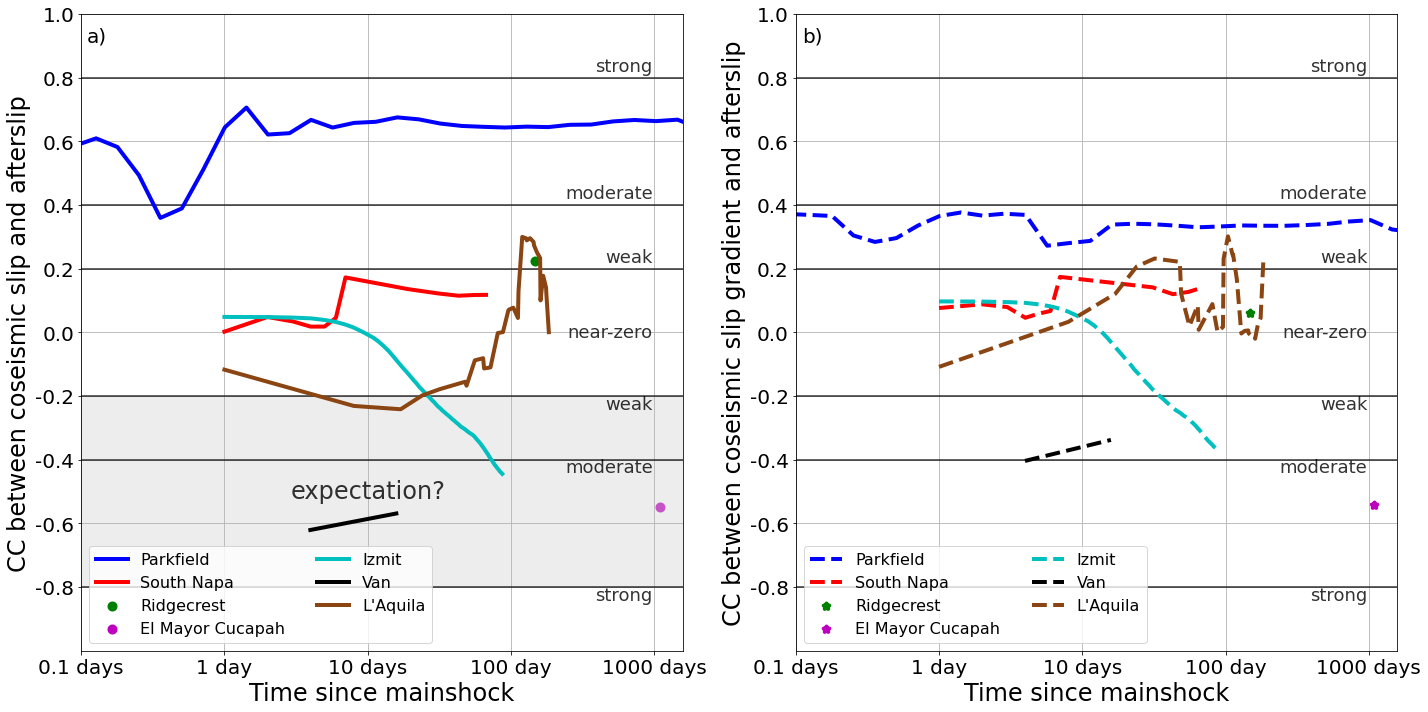

In [24]:
# Plot
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,2,1)
ax.plot([-1,3.2],[-0.8,-0.8],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[-0.4,-0.4],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[-0.2,-0.2],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.2,0.2],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.4,0.4],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.8,0.8],c = 'black',alpha = 0.8)
ax.text(2.99,0.82, 'strong', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.84, 'strong', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0.42, 'moderate', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.44, 'moderate', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0.22, 'weak', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.24, 'weak', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0, 'near-zero', fontsize = 18, alpha = 0.8,horizontalalignment='right',verticalalignment='center')
ax.text(1, -0.5, 'expectation?',fontsize = 24, alpha = 0.8,horizontalalignment='center',verticalalignment='center')

ax.plot(parklogdays,PARKCC,c = 'b',label = 'Parkfield', linewidth = 4) 
ax.plot(napalogdays,NAPACC,c = 'r',label = 'South Napa', linewidth = 4) 
ax.scatter(ridgelogdays,RIDGECC,c = 'g',label = 'Ridgecrest', linewidth = 4) 
ax.scatter(emclogdays,EMCCC,c = 'm',label = 'El Mayor Cucapah', linewidth = 4) 
ax.plot(izmitlogdays,IZMITCC,c = 'c',label = 'Izmit', linewidth = 4) 
ax.plot(vanlogdays,VANCC,c = 'black',label = 'Van', linewidth = 4) 
ax.plot(laqlogdays,LAQCC,c = 'saddlebrown',label = 'L\'Aquila', linewidth = 4) 
ax.add_patch(Rectangle((-1, -0.8),4.2, 0.6, facecolor = 'lightgrey',alpha = 0.4,fill=True))
ax.set_ylim([-1,1])
ax.set_xlim([-1,3.2])
ax.set_yticks([-0.8,-0.6,-0.4,-0.2,-0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels(["-0.8","-0.6","-0.4","-0.2","0.0","0.2","0.4","0.6","0.8","1.0"],fontsize = 20)
ax.set_xticks([-1,0,1,2,3])
ax.set_xticklabels(['0.1 days','1 day','10 days','100 day','1000 days'],fontsize = 20)
ax.set_xlabel('Time since mainshock',fontsize = 24)
ax.set_ylabel('CC between coseismic slip and afterslip',fontsize = 24)
ax.grid()
ax.text(0.01,0.98, 'a)',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes, fontsize = 20)
ax.legend(loc = 'lower left',fontsize = 16,ncol = 2)

ax = fig.add_subplot(1,2,2)
ax.plot([-1,3.2],[-0.8,-0.8],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[-0.4,-0.4],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[-0.2,-0.2],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.2,0.2],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.4,0.4],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.8,0.8],c = 'black',alpha = 0.8)
ax.text(2.99,0.82, 'strong', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.84, 'strong', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0.42, 'moderate', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.44, 'moderate', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0.22, 'weak', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.24, 'weak', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0, 'near-zero', fontsize = 18, alpha = 0.8,horizontalalignment='right',verticalalignment='center')

ax.plot(parklogdays,PARKGCC,c = 'b',label = 'Parkfield', linewidth = 4,linestyle = '--')
ax.plot(napalogdays,NAPAGCC,c = 'r',label = 'South Napa', linewidth = 4,linestyle = '--')
ax.scatter(ridgelogdays,RIDGEGCC,c = 'g',label = 'Ridgecrest', linewidth = 4, marker = '*') 
ax.scatter(emclogdays,EMCGCC,c = 'm',label = 'El Mayor Cucapah', linewidth = 4,marker = '*')
ax.plot(izmitlogdays,IZMITGCC,c = 'c',label = 'Izmit', linewidth = 4,linestyle = '--') 
ax.plot(vanlogdays,VANGCC,c = 'black',label = 'Van', linewidth = 4,linestyle = '--') 
ax.plot(laqlogdays,LAQGCC,c = 'saddlebrown',label = 'L\'Aquila', linewidth = 4,linestyle = '--') 
ax.set_ylim([-1,1])
ax.set_xlim([-1,3.2])
ax.set_yticks([-0.8,-0.6,-0.4,-0.2,-0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels(["-0.8","-0.6","-0.4","-0.2","0.0","0.2","0.4","0.6","0.8","1.0"],fontsize = 20)
ax.set_xticks([-1,0,1,2,3])
ax.set_xticklabels(['0.1 days','1 day','10 days','100 day','1000 days'],fontsize = 20)
ax.set_xlabel('Time since mainshock',fontsize = 24)
ax.set_ylabel('CC between coseismic slip gradient and afterslip',fontsize = 24)
ax.grid()
ax.text(0.01,0.98, 'b)',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes, fontsize = 20)
ax.legend(loc = 'lower left',fontsize = 16,ncol = 2)
plt.tight_layout()
fig.savefig('COSEISMICvAFTERSLIP.pdf', dpi=300)

## Coseismic Slip vs Aftershocks

In [25]:
# Calculations

# PARKFIELD
PARKDATA, PARKDATATRANS, PARKDATASTACK, PARKGRAD = getnewgridandgrad(PARKX,PARKY,PARKCO)
PARKGRAD = np.hstack(np.transpose(PARKGRAD))
PARKCC = []
PARKGCC = []
for i in range(len(aftershocktimes)):
    TIME = EVENTTIMES[0] + timedelta(days=aftershocktimes[i])
    PQoo = PQ[(PQ['mag'] >= 1.5) & (PQ['DIST'] <= 2.5) & (PQ['XXX'] >= 0) & (PQ['YYY'] <= 0) & (PQ['times']< TIME)]
    if len(PQoo) < 1:
        PAPACC.append(np.nan)
        PAPAGCC.append(np.nan)
    else:
        PARKSHOCKS = (PQoo['SHOCKSCROSSX'],PQoo['SHOCKSCROSSZ'])
        PARKXI, PARKYI, PARKSHOCKS =getnewgridSHOCKS(PARKX,PARKY,PARKSHOCKS)
        PARKCC.append(correlationwithnozeros(PARKDATASTACK,PARKSHOCKS)[0])
        PARKGCC.append(correlationwithnozeros(PARKGRAD,PARKSHOCKS)[0]) 


# NAPA
NAPADATA, NAPADATATRANS, NAPADATASTACK, NAPAGRAD = getnewgridandgradFOROVERLAP(NAPAX,NAPAY,NAPACO1,NAPACO2)
NAPAGRAD = np.hstack(np.transpose(NAPAGRAD))
NAPACC = []
NAPAGCC = []
for i in range(len(aftershocktimes)):
    TIME = EVENTTIMES[1] + timedelta(days=aftershocktimes[i])
    NQoo = NQ[(NQ['mag'] >= 1.5) & (NQ['DIST'] <= 2.5) & (NQ['XXX'] >= 0) & (NQ['YYY'] <= 0) & (NQ['times']< TIME)]
    if len(NQoo) < 1:
        NAPACC.append(np.nan)
        NAPAGCC.append(np.nan)
    else:
        NAPASHOCKS = (NQoo['SHOCKSCROSSX'],NQoo['SHOCKSCROSSZ'])
        NAPAXI, NAPAYI, NAPASHOCKS =getnewgridSHOCKS(NAPAX,NAPAY,NAPASHOCKS)
        NAPACC.append(correlationwithnozeros(NAPADATASTACK,NAPASHOCKS)[0])
        NAPAGCC.append(correlationwithnozeros(NAPAGRAD,NAPASHOCKS)[0]) 
        
# RIDGE
RIDGEDATA, RIDGEDATATRANS, RIDGEDATASTACK, RIDGEGRAD = getnewgridandgrad(RIDGEX,RIDGEY,RIDGECO)
RIDGEGRAD = np.hstack(np.transpose(RIDGEGRAD))
RIDGECC = []
RIDGEGCC = []
for i in range(len(aftershocktimes)):
    TIME = EVENTTIMES[2] + timedelta(days=aftershocktimes[i])
    RQoo = RQ[(RQ['mag'] >= 2.2) & (RQ['DIST'] <= 5) & (RQ['XXX'] >= 0) & (RQ['YYY'] <= 0) & (RQ['times']< TIME)]
    if len(RQoo) < 1:
        RIDGECC.append(np.nan)
        RIDGEGCC.append(np.nan)
    else:
        RIDGESHOCKS = (RQoo['SHOCKSCROSSX'],RQoo['SHOCKSCROSSZ'])
        RIDGEXI, RIDGEYI, RIDGESHOCKS =getnewgridSHOCKS(RIDGEX,RIDGEY,RIDGESHOCKS)
        RIDGECC.append(correlationwithnozeros(RIDGEDATASTACK,RIDGESHOCKS)[0])
        RIDGEGCC.append(correlationwithnozeros(RIDGEGRAD,RIDGESHOCKS)[0]) 
        
# EMC
EMCDATA, EMCDATATRANS, EMCDATASTACK, EMCGRAD = getnewgridandgrad(EMCX,EMCY,EMCCO)
EMCGRAD = np.hstack(np.transpose(EMCGRAD))
EMCCC = []
EMCGCC = []
for i in range(len(aftershocktimes)):
    TIME = EVENTTIMES[3] + timedelta(days=aftershocktimes[i])
    EQoo = EQ[(EQ['mag'] >= 2.2) & (EQ['DIST'] <= 5) & (EQ['XXX'] >= 0) & (EQ['YYY'] <= 0) & (EQ['times']< TIME)]
    if len(EQoo) < 1:
        EMCCC.append(np.nan)
        EMCGCC.append(np.nan)
    else:
        EMCSHOCKS = (EQoo['SHOCKSCROSSX'],EQoo['SHOCKSCROSSZ'])
        EMCXI, EMCYI, EMCSHOCKS = getnewgridSHOCKS(EMCX,EMCY,EMCSHOCKS)
        EMCCC.append(correlationwithnozeros(EMCDATASTACK,EMCSHOCKS)[0])
        EMCGCC.append(correlationwithnozeros(EMCGRAD,EMCSHOCKS)[0]) 
        
# IZMIT
IZMITDATA, IZMITDATATRANS, IZMITDATASTACK, IZMITGRAD = getnewgridandgrad(IZMITX,IZMITY,IZMITCO)
IZMITGRAD = np.hstack(np.transpose(IZMITGRAD))
IZMITCC = []
IZMITGCC = []
for i in range(len(aftershocktimes)):
    TIME = EVENTTIMES[4] + timedelta(days=aftershocktimes[i])
    IQoo = IQ[(IQ['mag'] >= 2.7) & (IQ['DIST'] <= 5) & (IQ['XXX'] >= 0) & (IQ['YYY'] <= 0) & (IQ['times']< TIME)]
    if len(IQoo) < 5:
        IZMITCC.append(np.nan)
        IZMITGCC.append(np.nan)
    else:
        IZMITSHOCKS = (IQoo['SHOCKSCROSSX'],IQoo['SHOCKSCROSSZ'])
        IZMITXI, IZMITYI, IZMITSHOCKS = getnewgridSHOCKS(IZMITX,IZMITY,IZMITSHOCKS)
        IZMITCC.append(correlationwithnozeros(IZMITDATASTACK,IZMITSHOCKS)[0])
        IZMITGCC.append(correlationwithnozeros(IZMITGRAD,IZMITSHOCKS)[0]) 
        
        
# VAN
VANDATA, VANDATATRANS, VANDATASTACK, VANGRAD = getnewgridandgrad(VANX,VANY,VANCO)
VANGRAD = np.hstack(np.transpose(VANGRAD))
VANCC = []
VANGCC = []
for i in range(len(aftershocktimes)):
    TIME = EVENTTIMES[5] + timedelta(days=aftershocktimes[i])
    VQoo = VQ[(VQ['mag'] >= 2.7) & (VQ['DIST'] <= 5) & (VQ['XXX'] >= 0) & (VQ['YYY'] >= 0) & (VQ['times']< TIME)]
    if len(VQoo) < 5:
        VANCC.append(np.nan)
        VANGCC.append(np.nan)
    else:
        VANSHOCKS = (VQoo['SHOCKSCROSSX'],VQoo['SHOCKSCROSSZ'])
        VANXI, VANYI, VANSHOCKS = getnewgridSHOCKS(VANX,VANY,VANSHOCKS)
        VANCC.append(correlationwithnozeros(VANDATASTACK,VANSHOCKS)[0])
        VANGCC.append(correlationwithnozeros(VANGRAD,VANSHOCKS)[0]) 
        
# LAQ
LAQDATA, LAQDATATRANS, LAQDATASTACK, LAQGRAD = getnewgridandgrad(LAQX,LAQY,LAQCO)
LAQGRAD = np.hstack(np.transpose(LAQGRAD))
LAQCC = []
LAQGCC = []
for i in range(len(aftershocktimes)):
    TIME = EVENTTIMES[6] + timedelta(days=aftershocktimes[i])
    LQoo = LQ[(LQ['mag'] >= 2.7) & (LQ['DIST'] <= 5) & (LQ['XXX'] >= 0) & (LQ['YYY'] <= 0) & (LQ['times']< TIME)]
    if len(IQoo) < 5:
        LAQCC.append(np.nan)
        LAQGCC.append(np.nan)
    else:
        LAQSHOCKS = (LQoo['SHOCKSCROSSX'],LQoo['SHOCKSCROSSZ'])
        LAQXI, LAQYI, LAQSHOCKS = getnewgridSHOCKS(LAQX,LAQY,LAQSHOCKS)
        LAQCC.append(correlationwithnozeros(LAQDATASTACK,LAQSHOCKS)[0])
        LAQGCC.append(correlationwithnozeros(LAQGRAD,LAQSHOCKS)[0]) 



/var/folders/ss/3c6ht1_957qfcmkn0qbrk5nx74dht3/T/ipykernel_4607/2852013917.py:265: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde(dataset)


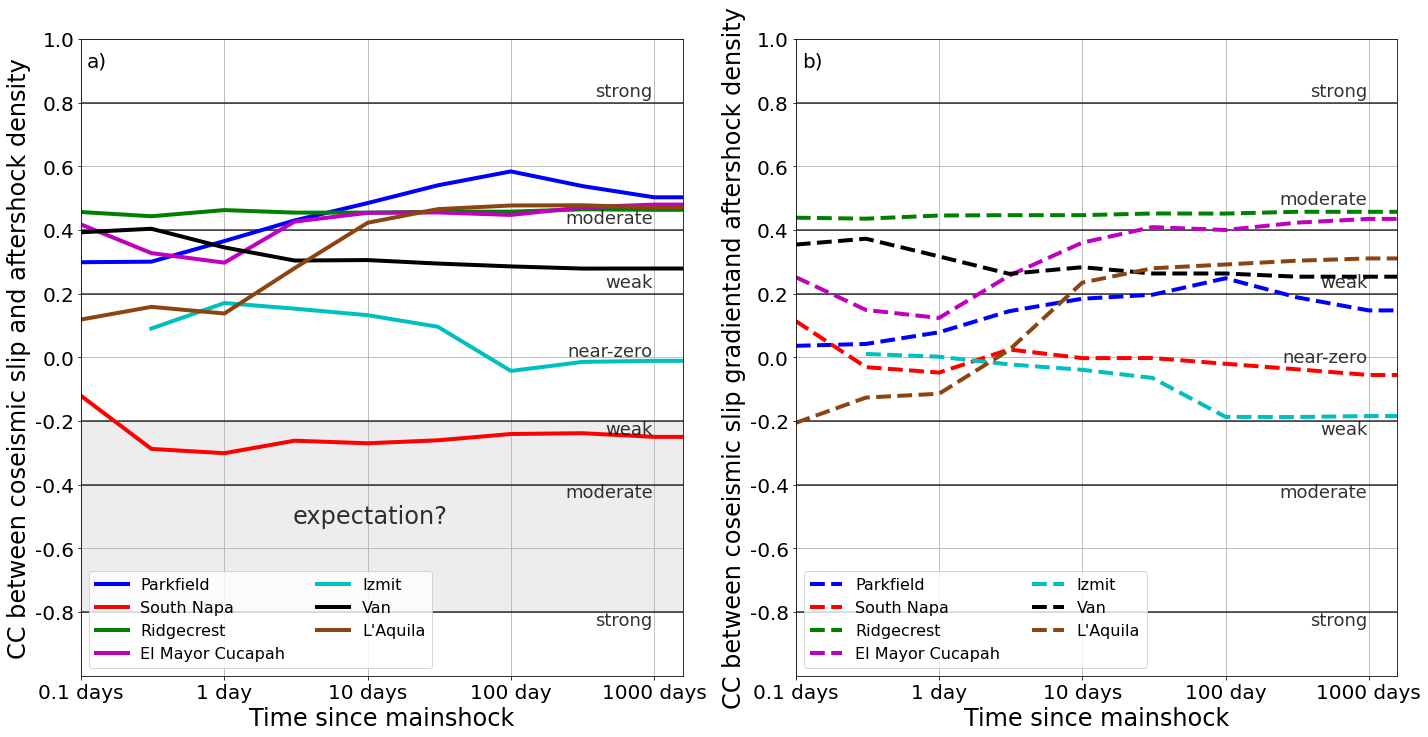

In [26]:
# Plots

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,2,1)
ax.plot([-1,3.2],[-0.8,-0.8],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[-0.4,-0.4],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[-0.2,-0.2],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.2,0.2],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.4,0.4],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.8,0.8],c = 'black',alpha = 0.8)
ax.text(2.99,0.82, 'strong', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.84, 'strong', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0.42, 'moderate', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.44, 'moderate', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0.22, 'weak', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.24, 'weak', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0.02, 'near-zero', fontsize = 18, alpha = 0.8,horizontalalignment='right',verticalalignment='center')

ax.text(1.02, -0.5, 'expectation?',fontsize = 24, alpha = 0.8,horizontalalignment='center',verticalalignment='center')

ax.plot(logtimes,PARKCC,c = 'b',label = 'Parkfield', linewidth = 4) 
ax.plot(logtimes,NAPACC,c = 'r',label = 'South Napa', linewidth = 4) 
ax.plot(logtimes,RIDGECC,c = 'g',label = 'Ridgecrest', linewidth = 4) 
ax.plot(logtimes,EMCCC,c = 'm',label = 'El Mayor Cucapah', linewidth = 4) 
ax.plot(logtimes,IZMITCC,c = 'c',label = 'Izmit', linewidth = 4) 
ax.plot(logtimes,VANCC,c = 'black',label = 'Van', linewidth = 4) 
ax.plot(logtimes,LAQCC,c = 'saddlebrown',label = 'L\'Aquila', linewidth = 4) 
ax.add_patch(Rectangle((-1, -0.8),4.2, 0.6, facecolor = 'lightgrey',alpha = 0.4,fill=True))
ax.set_ylim([-1,1])
ax.set_xlim([-1,3.2])
ax.set_yticks([-0.8,-0.6,-0.4,-0.2,-0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels(["-0.8","-0.6","-0.4","-0.2","0.0","0.2","0.4","0.6","0.8","1.0"],fontsize = 20)
ax.set_xticks([-1,0,1,2,3])
ax.set_xticklabels(['0.1 days','1 day','10 days','100 day','1000 days'],fontsize = 20)
ax.set_xlabel('Time since mainshock',fontsize = 24)
ax.set_ylabel('CC between coseismic slip and aftershock density',fontsize = 24)
ax.grid()
ax.text(0.01,0.98, 'a)',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes, fontsize = 20)
ax.legend(loc = 'lower left',fontsize = 16,ncol = 2)


ax = fig.add_subplot(1,2,2)
ax.plot([-1,3.2],[-0.8,-0.8],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[-0.4,-0.4],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[-0.2,-0.2],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.2,0.2],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.4,0.4],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.8,0.8],c = 'black',alpha = 0.8)
ax.text(2.99,0.82, 'strong', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.84, 'strong', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0.48, 'moderate', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.44, 'moderate', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0.22, 'weak', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.24, 'weak', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0, 'near-zero', fontsize = 18, alpha = 0.8,horizontalalignment='right',verticalalignment='center')

ax.plot(logtimes,PARKGCC,c = 'b',label = 'Parkfield', linewidth = 4,linestyle = '--')
ax.plot(logtimes,NAPAGCC,c = 'r',label = 'South Napa', linewidth = 4,linestyle = '--')
ax.plot(logtimes,RIDGEGCC,c = 'g',label = 'Ridgecrest', linewidth = 4,linestyle = '--') 
ax.plot(logtimes,EMCGCC,c = 'm',label = 'El Mayor Cucapah', linewidth = 4,linestyle = '--')
ax.plot(logtimes,IZMITGCC,c = 'c',label = 'Izmit', linewidth = 4,linestyle = '--') 
ax.plot(logtimes,VANGCC,c = 'black',label = 'Van', linewidth = 4,linestyle = '--') 
ax.plot(logtimes,LAQGCC,c = 'saddlebrown',label = 'L\'Aquila', linewidth = 4,linestyle = '--') 
ax.set_xlabel('Time since mainshock',fontsize = 24)
ax.set_ylim([-1,1])
ax.set_xlim([-1,3.2])
ax.set_yticks([-0.8,-0.6,-0.4,-0.2,-0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels(["-0.8","-0.6","-0.4","-0.2","0.0","0.2","0.4","0.6","0.8","1.0"],fontsize = 20)
ax.set_xticks([-1,0,1,2,3])
ax.set_xticklabels(['0.1 days','1 day','10 days','100 day','1000 days'],fontsize = 20)
ax.set_ylabel('CC between coseismic slip gradientand aftershock density',fontsize = 24)
ax.grid()
ax.text(0.01,0.98, 'b)',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes, fontsize = 20)
ax.legend(loc = 'lower left',fontsize = 16,ncol = 2)

plt.tight_layout()
fig.savefig('COSEISMICvAFTERSHOCK.pdf', dpi=300)

## Afterslip vs Aftershocks

In [27]:
# Calculations

# PARKFIELD
PARKCC = []
PARKGCC = []
parklogdays = []
for i in range(1,27):
    TIME = parktimesteps[i]
    parklogdays.append(math.log10(parktimes_inseconds[i]/(24*60*60)))
    PQoo = PQ[(PQ['mag'] >= 1.5) & (PQ['DIST'] <= 2.5) & (PQ['XXX'] >= 0) & (PQ['YYY'] <= 0) & (PQ['times']< TIME)]
    PARKAFT = [PSLIPCROSSX1, PSLIPCROSSZ1,parkslip[i]] #
    PARKSDATA, PARKSDATATRANS, PARKSDATASTACK, PARKSGRAD = getnewgridandgrad(PARKX,PARKY,PARKAFT)
    PARKSGRAD = np.hstack(np.transpose(PARKSGRAD))
    if len(PQoo) < 5:
        PARKCC.append(np.nan)
        PARKGCC.append(np.nan)
    else:
        PARKSHOCKS = (PQoo['SHOCKSCROSSX'],PQoo['SHOCKSCROSSZ'])
        PARKXI, PARKYI, PARKSHOCKS =getnewgridSHOCKS(PARKX,PARKY,PARKSHOCKS)
        PARKCC.append(correlationwithnozeros(PARKSDATASTACK,PARKSHOCKS)[0])
        PARKGCC.append(correlationwithnozeros(PARKSGRAD,PARKSHOCKS)[0])
for i in range(27,45):
    TIME = parktimesteps[i]
    parklogdays.append(math.log10(parktimes_inseconds[i]/(24*60*60)))
    PQoo = PQ[(PQ['mag'] >= 1.5) & (PQ['DIST'] <= 2.5) & (PQ['XXX'] >= 0) & (PQ['YYY'] <= 0) & (PQ['times']< TIME)]
    PARKAFT = [PSLIPCROSSX2, PSLIPCROSSZ2,parkslip[i]] #
    PARKSDATA, PARKSDATATRANS, PARKSDATASTACK, PARKSGRAD = getnewgridandgrad(PARKX,PARKY,PARKAFT)
    PARKSGRAD = np.hstack(np.transpose(PARKSGRAD))
    PARKSHOCKS = (PQoo['SHOCKSCROSSX'],PQoo['SHOCKSCROSSZ'])
    PARKXI, PARKYI, PARKSHOCKS =getnewgridSHOCKS(PARKX,PARKY,PARKSHOCKS)
    PARKCC.append(correlationwithnozeros(PARKSDATASTACK,PARKSHOCKS)[0])
    PARKGCC.append(correlationwithnozeros(PARKSGRAD,PARKSHOCKS)[0])   
        
# NAPA
NAPACC = []
NAPAGCC = []
napalogdays = []
for i in range(1,13):
    TIME = napatimesteps[i]
    NQoo = NQ[(NQ['mag'] >= 1.5) & (NQ['DIST'] <= 2.5) & (NQ['XXX'] >= 0) & (NQ['YYY'] <= 0) & (NQ['times']< TIME)]
    napalogdays.append(math.log10(napatimes_indays[i]))
    NAPAAFT1 = [[],[],[]] # THE MAINFAULT
    NAPAAFT2 = [[],[],[]] # THE OVERLAPPERS (add these two)
    napatempaft = napaslip[i]
    for j in range(len(napasegsno)):
        if napasegsno[j] == 1 or napasegsno[j] == 7:
            NAPAAFT2[0].append(NSLIPCROSSX1[j])
            NAPAAFT2[1].append(NSLIPCROSSZ1[j])
            NAPAAFT2[2].append(napatempaft[j])
        else:
            NAPAAFT1[0].append(NSLIPCROSSX1[j])
            NAPAAFT1[1].append(NSLIPCROSSZ1[j])
            NAPAAFT1[2].append(napatempaft[j])        
    NAPASDATA, NAPASDATATRANS, NAPASDATASTACK, NAPASGRAD = getnewgridandgradFOROVERLAP(NAPAX,NAPAY,NAPAAFT1,NAPAAFT2)    
    NAPASGRAD = np.hstack(np.transpose(NAPASGRAD))
    if len(NQoo) < 5:
        NAPACC.append(np.nan)
        NAPAGCC.append(np.nan)
    else:
        NAPASHOCKS = (NQoo['SHOCKSCROSSX'],NQoo['SHOCKSCROSSZ'])
        NAPAXI, NAPAYI, NAPASHOCKS =getnewgridSHOCKS(NAPAX,NAPAY,NAPASHOCKS)
        NAPACC.append(correlationwithnozeros(NAPASDATASTACK,NAPASHOCKS)[0])
        NAPAGCC.append(correlationwithnozeros(NAPASGRAD,NAPASHOCKS)[0]) 

# RIDGE
RIDGECC = []
RIDGEGCC = []
ridgelogdays = [2.17]
RIDGEAFT1 = [[],[],[]] # THE MAINFAULT
RIDGEAFT2 = [[],[],[]] # THE OVERLAPPERS (add these two) # AFT (1)
for i in range(len(yueridgesegsnums)):
    if yueridgesegsnums[i] == 2 or yueridgesegsnums[i] == 3 or yueridgesegsnums[i] == 5 or yueridgesegsnums[i] == 6:
        RIDGEAFT2[0].append(RSLIPCROSSX1[i])
        RIDGEAFT2[1].append(RSLIPCROSSZ1[i])
        RIDGEAFT2[2].append(ridgetempaft[i])
    else:
        RIDGEAFT1[0].append(RSLIPCROSSX1[i])
        RIDGEAFT1[1].append(RSLIPCROSSZ1[i])
        RIDGEAFT1[2].append(ridgetempaft[i])         
RIDGESDATA, RIDGESDATATRANS, RIDGESDATASTACK, RIDGESGRAD = getnewgridandgradFOROVERLAP(RIDGEX,RIDGEY,RIDGEAFT1,RIDGEAFT2)
RIDGESGRAD = np.hstack(np.transpose(RIDGESGRAD))
TIME = EVENTTIMES[2] + timedelta(days=150)
RQoo = RQ[(RQ['mag'] >= 2.2) & (RQ['DIST'] <= 5) & (RQ['XXX'] >= 0) & (RQ['YYY'] <= 0) & (RQ['times']< TIME)]
RIDGESHOCKS = (RQoo['SHOCKSCROSSX'],RQoo['SHOCKSCROSSZ'])
RIDGEXI, RIDGEYI, RIDGESHOCKS =getnewgridSHOCKS(RIDGEX,RIDGEY,RIDGESHOCKS)
RIDGECC.append(correlationwithnozeros(RIDGESDATASTACK,RIDGESHOCKS)[0])
RIDGEGCC.append(correlationwithnozeros(RIDGESGRAD,RIDGESHOCKS)[0])    
TIME = EVENTTIMES[2] + timedelta(days=730)
RQoo = RQ[(RQ['mag'] >= 2.2) & (RQ['DIST'] <= 5) & (RQ['XXX'] >= 0) & (RQ['YYY'] <= 0) & (RQ['times']< TIME)]
RIDGESHOCKS = (RQoo['SHOCKSCROSSX'],RQoo['SHOCKSCROSSZ'])
RIDGEXI, RIDGEYI, RIDGESHOCKS =getnewgridSHOCKS(RIDGEX,RIDGEY,RIDGESHOCKS)



# EMC
EMCPROJ1, ESLIPCROSSX1, ESLIPCROSSZ1,EDISTS1 = pointstoplane(EXYZ1,ENORM,ED,EPOP,0) # AFT
EMCPROJ2, ESLIPCROSSX2, ESLIPCROSSZ2,EDISTS2 = pointstoplane(ECOXYZ1,ENORM,ED,EPOP,0) #CO
ESLIPCROSSX1 = np.append(ESLIPCROSSX1,(40,40,40,40,40,40,40,40,   40,45,50,55,60,65,70,75,80,85,90,   90,90,90,90,90))
ESLIPCROSSZ1 = np.append(ESLIPCROSSZ1,(2,4,6,8,10,12,14,15,   14,14,14,14,14,14,14,14,14,14,14,   10,11,12,13,15))
emctempaft = np.append(emcslip,np.zeros([24]))
# ^^^ I append 24 0 points to the afterslip model to stop it interpolating in between them (bc they're so irregularly spaced)
EMCCC = []
EMCGCC = []
emclogdays = [3.04]
EMCAFT = [ESLIPCROSSX1, ESLIPCROSSZ1,emctempaft] # AFT (2)    
EMCSDATA, EMCSDATATRANS, EMCSDATASTACK, EMCSGRAD = getnewgridandgrad(EMCX,EMCY,EMCAFT)
EMCSGRAD = np.hstack(np.transpose(EMCSGRAD))
TIME = EVENTTIMES[3] + timedelta(days=1096)
EQoo = EQ[(EQ['mag'] >= 2.2) & (EQ['DIST'] <= 5) & (EQ['XXX'] >= 0) & (EQ['YYY'] <= 0) & (EQ['times']< TIME)]
EMCSHOCKS = (EQoo['SHOCKSCROSSX'],EQoo['SHOCKSCROSSZ'])
EMCXI, EMCYI, EMCSHOCKS =getnewgridSHOCKS(EMCX,EMCY,EMCSHOCKS)
EMCCC.append(correlationwithnozeros(EMCSDATASTACK,EMCSHOCKS)[0])
EMCGCC.append(correlationwithnozeros(EMCSGRAD,EMCSHOCKS)[0])    

# IZMIT
IZMITCC = []
IZMITGCC = []
izmitlogdays = []
for i in range(len(izmitslip)):
    TIME = izmittimesteps[i]
    izmitlogdays.append(math.log10((datetime.timestamp(izmittimesteps[i])-datetime.timestamp(EVENTTIMES[4]))/(24*60*60)))
    IQoo = IQ[(IQ['mag'] >= 2.7) & (IQ['DIST'] <= 5) & (IQ['XXX'] >= 0) & (IQ['YYY'] <= 0) & (IQ['times']< TIME)]
    IZMITAFT = [ISLIPCROSSX1, ISLIPCROSSZ1,izmitslip[i]] #
    IZMITSDATA, IZMITSDATATRANS, IZMITSDATASTACK, IZMITSGRAD = getnewgridandgrad(IZMITX,IZMITY,IZMITAFT)
    IZMITSGRAD = np.hstack(np.transpose(IZMITSGRAD))
    IZMITSHOCKS = (IQoo['SHOCKSCROSSX'],IQoo['SHOCKSCROSSZ'])
    IZMITXI, IZMITYI, IZMITSHOCKS =getnewgridSHOCKS(IZMITX,IZMITY,IZMITSHOCKS)
    IZMITCC.append(correlationwithnozeros(IZMITSDATASTACK,IZMITSHOCKS)[0])
    IZMITGCC.append(correlationwithnozeros(IZMITSGRAD,IZMITSHOCKS)[0])
    
# VAN
VANCC = []
VANGCC = []
vanlogdays = [0.6,1.23]
TIME = EVENTTIMES[5] + timedelta(days=4)
VQoo = VQ[(VQ['mag'] >= 2.7) & (VQ['DIST'] <= 5) & (VQ['XXX'] >= 0) & (VQ['YYY'] >= 0) & (VQ['times']< TIME)]
VANAFT = [VSLIPCROSSX1, VSLIPCROSSZ1,vanslip[0]]
VANSDATA, VANSDATATRANS, VANSDATASTACK, VANSGRAD = getnewgridandgrad(VANX,VANY,VANAFT)
VANSGRAD = np.hstack(np.transpose(VANSGRAD))
VANSHOCKS = (VQoo['SHOCKSCROSSX'],VQoo['SHOCKSCROSSZ'])
VANXI, VANYI, VANSHOCKS =getnewgridSHOCKS(VANX,VANY,VANSHOCKS)
VANCC.append(correlationwithnozeros(VANSDATASTACK,VANSHOCKS)[0])
VANGCC.append(correlationwithnozeros(VANSGRAD,VANSHOCKS)[0])

TIME = EVENTTIMES[5] + timedelta(days=17)
VQoo = VQ[(VQ['mag'] >= 2.7) & (VQ['DIST'] <= 5) & (VQ['XXX'] >= 0) & (VQ['YYY'] >= 0) & (VQ['times']< TIME)]
VANAFT = [VSLIPCROSSX1, VSLIPCROSSZ1,vanslip[1]]
VANSDATA, VANSDATATRANS, VANSDATASTACK, VANSGRAD = getnewgridandgrad(VANX,VANY,VANAFT)
VANSGRAD = np.hstack(np.transpose(VANSGRAD))
VANSHOCKS = (VQoo['SHOCKSCROSSX'],VQoo['SHOCKSCROSSZ'])
VANXI, VANYI, VANSHOCKS =getnewgridSHOCKS(VANX,VANY,VANSHOCKS)
VANCC.append(correlationwithnozeros(VANSDATASTACK,VANSHOCKS)[0])
VANGCC.append(correlationwithnozeros(VANSGRAD,VANSHOCKS)[0])

# LAQ
LAQCC = []
LAQGCC = []
laqlogdays = []
for i in range(len(laqslip)):
    TIME = laqtimesteps[i]
    laqlogdays.append(math.log10((datetime.timestamp(laqtimesteps[i])-datetime.timestamp(EVENTTIMES[6]))/(24*60*60)))
    LQoo = LQ[(LQ['mag'] >= 2.7) & (LQ['DIST'] <= 5) & (LQ['XXX'] >= 0) & (LQ['YYY'] <= 0) & (LQ['times']< TIME)]
    LAQAFT = [LSLIPCROSSX1, LSLIPCROSSZ1,laqslip[i]] #
    LAQSDATA, LAQSDATATRANS, LAQSDATASTACK, LAQSGRAD = getnewgridandgrad(LAQX,LAQY,LAQAFT)
    LAQSGRAD = np.hstack(np.transpose(LAQSGRAD))
    LAQSHOCKS = (LQoo['SHOCKSCROSSX'],LQoo['SHOCKSCROSSZ'])
    LAQXI, LAQYI, LAQSHOCKS =getnewgridSHOCKS(LAQX,LAQY,LAQSHOCKS)
    LAQCC.append(correlationwithnozeros(LAQSDATASTACK,LAQSHOCKS)[0])
    LAQGCC.append(correlationwithnozeros(LAQSGRAD,LAQSHOCKS)[0])
    

/var/folders/ss/3c6ht1_957qfcmkn0qbrk5nx74dht3/T/ipykernel_4607/2852013917.py:265: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde(dataset)


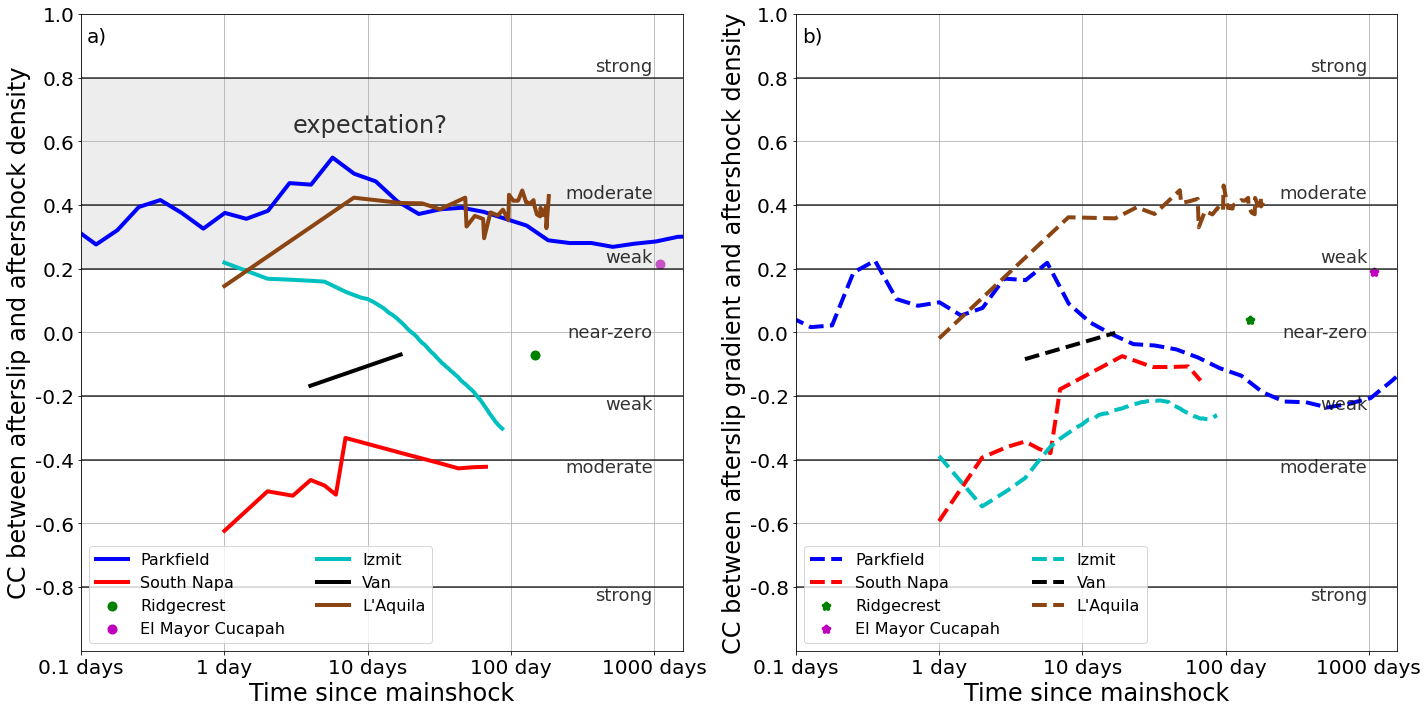

In [28]:
# Plots

fig = plt.figure(figsize = (20,10))

ax = fig.add_subplot(1,2,1)
ax.plot([-1,3.2],[-0.8,-0.8],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[-0.4,-0.4],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[-0.2,-0.2],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.2,0.2],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.4,0.4],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.8,0.8],c = 'black',alpha = 0.8)
ax.text(2.99,0.82, 'strong', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.84, 'strong', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0.42, 'moderate', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.44, 'moderate', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0.22, 'weak', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.24, 'weak', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0, 'near-zero', fontsize = 18, alpha = 0.8,horizontalalignment='right',verticalalignment='center')

ax.text(1.02, 0.65, 'expectation?',fontsize = 24, alpha = 0.8,horizontalalignment='center',verticalalignment='center')

ax.plot(parklogdays,PARKCC,c = 'b',label = 'Parkfield', linewidth = 4) 
ax.plot(napalogdays,NAPACC,c = 'r',label = 'South Napa', linewidth = 4) 
ax.scatter(ridgelogdays,RIDGECC,c = 'g',label = 'Ridgecrest', linewidth = 4) 
ax.scatter(emclogdays,EMCCC,c = 'm',label = 'El Mayor Cucapah', linewidth = 4) 
ax.plot(izmitlogdays,IZMITCC,c = 'c',label = 'Izmit', linewidth = 4) 
ax.plot(vanlogdays,VANCC,c = 'black',label = 'Van', linewidth = 4) 
ax.plot(laqlogdays,LAQCC,c = 'saddlebrown',label = 'L\'Aquila', linewidth = 4) 
ax.add_patch(Rectangle((-1, 0.2),4.2, 0.6, facecolor = 'lightgrey',alpha = 0.4,fill=True))
ax.set_ylim([-1,1])
ax.set_xlim([-1,3.2])
ax.set_yticks([-0.8,-0.6,-0.4,-0.2,-0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels(["-0.8","-0.6","-0.4","-0.2","0.0","0.2","0.4","0.6","0.8","1.0"],fontsize = 20)
ax.set_xticks([-1,0,1,2,3])
ax.set_xticklabels(['0.1 days','1 day','10 days','100 day','1000 days'],fontsize = 20)
ax.set_xlabel('Time since mainshock',fontsize = 24)
ax.set_ylabel('CC between afterslip and aftershock density',fontsize = 24)
ax.grid()
ax.text(0.01,0.98, 'a)',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes, fontsize = 20)
ax.legend(loc = 'lower left',fontsize = 16,ncol = 2)


ax = fig.add_subplot(1,2,2)
ax.plot([-1,3.2],[-0.8,-0.8],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[-0.4,-0.4],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[-0.2,-0.2],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.2,0.2],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.4,0.4],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.8,0.8],c = 'black',alpha = 0.8)
ax.text(2.99,0.82, 'strong', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.84, 'strong', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0.42, 'moderate', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.44, 'moderate', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0.22, 'weak', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.24, 'weak', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0, 'near-zero', fontsize = 18, alpha = 0.8,horizontalalignment='right',verticalalignment='center')

ax.plot(parklogdays,PARKGCC,c = 'b',label = 'Parkfield',linewidth = 4,linestyle = '--')
ax.plot(napalogdays,NAPAGCC,c = 'r',label = 'South Napa',linewidth = 4,linestyle = '--')
ax.scatter(ridgelogdays,RIDGEGCC,c = 'g',label = 'Ridgecrest',linewidth = 4,marker = '*') 
ax.scatter(emclogdays,EMCGCC,c = 'm',label = 'El Mayor Cucapah',linewidth = 4,marker = '*')
ax.plot(izmitlogdays,IZMITGCC,c = 'c',label = 'Izmit',linewidth = 4,linestyle = '--') 
ax.plot(vanlogdays,VANGCC,c = 'black',label = 'Van',linewidth = 4,linestyle = '--') 
ax.plot(laqlogdays,LAQGCC,c = 'saddlebrown',label = 'L\'Aquila',linewidth = 4,linestyle = '--') 
ax.set_ylim([-1,1])
ax.set_xlim([-1,3.2])
ax.set_yticks([-0.8,-0.6,-0.4,-0.2,-0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels(["-0.8","-0.6","-0.4","-0.2","0.0","0.2","0.4","0.6","0.8","1.0"],fontsize = 20)
ax.set_xticks([-1,0,1,2,3])
ax.set_xlabel('Time since mainshock',fontsize = 24)
ax.set_ylabel('CC between afterslip gradient and aftershock density',fontsize = 24)
ax.set_xticklabels(['0.1 days','1 day','10 days','100 day','1000 days'],fontsize = 20)
ax.grid()
ax.text(0.01,0.98, 'b)',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes, fontsize = 20)
ax.legend(loc = 'lower left',fontsize = 16,ncol = 2)

plt.tight_layout()
fig.savefig('AFTERSLIPvAFTERSHOCK.pdf', dpi=300)

## Cumulative Slip vs Aftershocks

In [29]:
# Calculations

# PARKFIELD
PARKCC = []
PARKGCC = []
parklogdays = []
for i in range(1,27):
    TIME = parktimesteps[i]
    parklogdays.append(math.log10(parktimes_inseconds[i]/(24*60*60)))
    PQoo = PQ[(PQ['mag'] >= 1.5) & (PQ['DIST'] <= 2.5) & (PQ['XXX'] >= 0) & (PQ['YYY'] <= 0) & (PQ['times']< TIME)]
    PARKAFT = [PSLIPCROSSX1, PSLIPCROSSZ1,parkslip[i]] #
    PARKDATA, PARKDATATRANS, PARKDATASTACK, PARKGRAD = getnewgridandgrad(PARKX,PARKY,PARKCO) # CO
    PARKSDATA, PARKSDATATRANS, PARKSDATASTACK, PARKSGRAD = getnewgridandgrad(PARKX,PARKY,PARKAFT) # AFT
    PARKSDATA, PARKSDATATRANS, PARKSDATASTACK, PARKSGRAD = getnewgridandgradFOROVERLAP(PARKX,PARKY,PARKCO,PARKAFT)
    PARKSGRAD = np.hstack(np.transpose(PARKSGRAD))
    if len(PQoo) < 5:
        PARKCC.append(np.nan)
        PARKGCC.append(np.nan)
    else:
        PARKSHOCKS = (PQoo['SHOCKSCROSSX'],PQoo['SHOCKSCROSSZ'])
        PARKXI, PARKYI, PARKSHOCKS =getnewgridSHOCKS(PARKX,PARKY,PARKSHOCKS)
        PARKCC.append(correlationwithnozeros(PARKSDATASTACK,PARKSHOCKS)[0])
        PARKGCC.append(correlationwithnozeros(PARKSGRAD,PARKSHOCKS)[0])
for i in range(27,45):
    TIME = parktimesteps[i]
    parklogdays.append(math.log10(parktimes_inseconds[i]/(24*60*60)))
    PQoo = PQ[(PQ['mag'] >= 1.5) & (PQ['DIST'] <= 2.5) & (PQ['XXX'] >= 0) & (PQ['YYY'] <= 0) & (PQ['times']< TIME)]
    PARKAFT = [PSLIPCROSSX2, PSLIPCROSSZ2,parkslip[i]] #
    PARKDATA, PARKDATATRANS, PARKDATASTACK, PARKGRAD = getnewgridandgrad(PARKX,PARKY,PARKCO) # CO
    PARKSDATA, PARKSDATATRANS, PARKSDATASTACK, PARKSGRAD = getnewgridandgrad(PARKX,PARKY,PARKAFT) # AFT
    PARKSDATA, PARKSDATATRANS, PARKSDATASTACK, PARKSGRAD = getnewgridandgradFOROVERLAP(PARKX,PARKY,PARKCO,PARKAFT)
    PARKSGRAD = np.hstack(np.transpose(PARKSGRAD))
    PARKSHOCKS = (PQoo['SHOCKSCROSSX'],PQoo['SHOCKSCROSSZ'])
    PARKXI, PARKYI, PARKSHOCKS =getnewgridSHOCKS(PARKX,PARKY,PARKSHOCKS)
    PARKCC.append(correlationwithnozeros(PARKSDATASTACK,PARKSHOCKS)[0])
    PARKGCC.append(correlationwithnozeros(PARKSGRAD,PARKSHOCKS)[0])   
 
        
# NAPA
NAPACC = []
NAPAGCC = []
napalogdays = []
for i in range(1,13):
    TIME = napatimesteps[i]
    NQoo = NQ[(NQ['mag'] >= 1.5) & (NQ['DIST'] <= 2.5) & (NQ['XXX'] >= 0) & (NQ['YYY'] <= 0) & (NQ['times']< TIME)]
    napalogdays.append(math.log10(napatimes_indays[i]))
    NAPAAFT1 = [[],[],[]] # THE MAINFAULT
    NAPAAFT2 = [[],[],[]] # THE OVERLAPPERS (add these two)
    napatempaft = napaslip[i]
    for j in range(len(napasegsno)):
        if napasegsno[j] == 1 or napasegsno[j] == 7:
            NAPAAFT2[0].append(NSLIPCROSSX1[j])
            NAPAAFT2[1].append(NSLIPCROSSZ1[j])
            NAPAAFT2[2].append(napatempaft[j])
        else:
            NAPAAFT1[0].append(NSLIPCROSSX1[j])
            NAPAAFT1[1].append(NSLIPCROSSZ1[j])
            NAPAAFT1[2].append(napatempaft[j]) 
    NAPACO1 = [[],[],[]] # THE MAINFAULT
    NAPACO2 = [[],[],[]] # THE OVERLAPPERS (add these two)
    napatempco = napaco
    for j in range(len(napasegsno)):
        if napasegsno[j] == 1 or napasegsno[j] == 7:
            NAPACO2[0].append(NSLIPCROSSX1[j])
            NAPACO2[1].append(NSLIPCROSSZ1[j])
            NAPACO2[2].append(napatempco[j])
        else:
            NAPACO1[0].append(NSLIPCROSSX1[j])
            NAPACO1[1].append(NSLIPCROSSZ1[j])
            NAPACO1[2].append(napatempco[j]) 
    NAPASDATA, NAPASDATATRANS, NAPASDATASTACK, NAPASGRAD = getnewgridandgradFOROVERLAP4(NAPAX,NAPAY,NAPAAFT1,NAPAAFT2,NAPACO1,NAPACO2)
    NAPASGRAD = np.hstack(np.transpose(NAPASGRAD))
    if len(NQoo) < 5:
        NAPACC.append(np.nan)
        NAPAGCC.append(np.nan)
        print('yes')
    else:
        NAPASHOCKS = (NQoo['SHOCKSCROSSX'],NQoo['SHOCKSCROSSZ'])
        NAPAXI, NAPAYI, NAPASHOCKS =getnewgridSHOCKS(NAPAX,NAPAY,NAPASHOCKS)
        NAPACC.append(correlationwithnozeros(NAPASDATASTACK,NAPASHOCKS)[0])
        NAPAGCC.append(correlationwithnozeros(NAPASGRAD,NAPASHOCKS)[0]) 

# RIDGE
RIDGECC = []
RIDGEGCC = []
ridgelogdays = [2.17]
RIDGEAFT1 = [[],[],[]] # THE MAINFAULT
RIDGEAFT2 = [[],[],[]] # THE OVERLAPPERS (add these two) # AFT (1)
for i in range(len(yueridgesegsnums)):
    if yueridgesegsnums[i] == 2 or yueridgesegsnums[i] == 3 or yueridgesegsnums[i] == 5 or yueridgesegsnums[i] == 6:
        RIDGEAFT2[0].append(RSLIPCROSSX1[i])
        RIDGEAFT2[1].append(RSLIPCROSSZ1[i])
        RIDGEAFT2[2].append(ridgetempaft[i])
    else:
        RIDGEAFT1[0].append(RSLIPCROSSX1[i])
        RIDGEAFT1[1].append(RSLIPCROSSZ1[i])
        RIDGEAFT1[2].append(ridgetempaft[i])         
RIDGESDATA, RIDGESDATATRANS, RIDGESDATASTACK, RIDGESGRAD = getnewgridandgradFOROVERLAP3(RIDGEX,RIDGEY,RIDGEAFT1,RIDGEAFT2,RIDGECO)
RIDGESGRAD = np.hstack(np.transpose(RIDGESGRAD))
TIME = EVENTTIMES[2] + timedelta(days=150)
RQoo = RQ[(RQ['mag'] >= 2.2) & (RQ['DIST'] <= 5) & (RQ['XXX'] >= 0) & (RQ['YYY'] <= 0) & (RQ['times']< TIME)]
RIDGESHOCKS = (RQoo['SHOCKSCROSSX'],RQoo['SHOCKSCROSSZ'])
RIDGEXI, RIDGEYI, RIDGESHOCKS =getnewgridSHOCKS(RIDGEX,RIDGEY,RIDGESHOCKS)
RIDGECC.append(correlationwithnozeros(RIDGESDATASTACK,RIDGESHOCKS)[0])
RIDGEGCC.append(correlationwithnozeros(RIDGESGRAD,RIDGESHOCKS)[0])    
TIME = EVENTTIMES[2] + timedelta(days=730)
RQoo = RQ[(RQ['mag'] >= 2.2) & (RQ['DIST'] <= 5) & (RQ['XXX'] >= 0) & (RQ['YYY'] <= 0) & (RQ['times']< TIME)]
RIDGESHOCKS = (RQoo['SHOCKSCROSSX'],RQoo['SHOCKSCROSSZ'])
RIDGEXI, RIDGEYI, RIDGESHOCKS =getnewgridSHOCKS(RIDGEX,RIDGEY,RIDGESHOCKS)


# EMC
EMCPROJ1, ESLIPCROSSX1, ESLIPCROSSZ1,EDISTS1 = pointstoplane(EXYZ1,ENORM,ED,EPOP,0) # AFT
EMCPROJ2, ESLIPCROSSX2, ESLIPCROSSZ2,EDISTS2 = pointstoplane(ECOXYZ1,ENORM,ED,EPOP,0) #CO
ESLIPCROSSX1 = np.append(ESLIPCROSSX1,(40,40,40,40,40,40,40,40,   40,45,50,55,60,65,70,75,80,85,90,   90,90,90,90,90))
ESLIPCROSSZ1 = np.append(ESLIPCROSSZ1,(2,4,6,8,10,12,14,15,   14,14,14,14,14,14,14,14,14,14,14,   10,11,12,13,15))
emctempaft = np.append(emcslip,np.zeros([24]))
# ^^^ I append 24 0 points to the afterslip model to stop it interpolating in between them (bc they're so irregularly spaced)
EMCCC = []
EMCGCC = []
emclogdays = [3.04]
EMCAFT = [ESLIPCROSSX1, ESLIPCROSSZ1,emctempaft] # AFT (2)    
EMCSDATA, EMCSDATATRANS, EMCSDATASTACK, EMCSGRAD = getnewgridandgrad(EMCX,EMCY,EMCAFT)
EMCSGRAD = np.hstack(np.transpose(EMCSGRAD))
TIME = EVENTTIMES[3] + timedelta(days=1096)
EQoo = EQ[(EQ['mag'] >= 2.2) & (EQ['DIST'] <= 5) & (EQ['XXX'] >= 0) & (EQ['YYY'] <= 0) & (EQ['times']< TIME)]
EMCSHOCKS = (EQoo['SHOCKSCROSSX'],EQoo['SHOCKSCROSSZ'])
EMCXI, EMCYI, EMCSHOCKS =getnewgridSHOCKS(EMCX,EMCY,EMCSHOCKS)
EMCCC.append(correlationwithnozeros(EMCSDATASTACK,EMCSHOCKS)[0])
EMCGCC.append(correlationwithnozeros(EMCSGRAD,EMCSHOCKS)[0])    

# IZMIT
IZMITCC = []
IZMITGCC = []
izmitlogdays = []
for i in range(len(izmitslip)):
    TIME = izmittimesteps[i]
    izmitlogdays.append(math.log10((datetime.timestamp(izmittimesteps[i])-datetime.timestamp(EVENTTIMES[4]))/(24*60*60)))
    IQoo = IQ[(IQ['mag'] >= 2.7) & (IQ['DIST'] <= 5) & (IQ['XXX'] >= 0) & (IQ['YYY'] <= 0) & (IQ['times']< TIME)]
    IZMITAFT = [ISLIPCROSSX1, ISLIPCROSSZ1,izmitslip[i]] #
    IZMITSDATA, IZMITSDATATRANS, IZMITSDATASTACK, IZMITSGRAD = getnewgridandgradFOROVERLAP(IZMITX,IZMITY,IZMITAFT,IZMITCO)
    IZMITSGRAD = np.hstack(np.transpose(IZMITSGRAD))
    IZMITSHOCKS = (IQoo['SHOCKSCROSSX'],IQoo['SHOCKSCROSSZ'])
    IZMITXI, IZMITYI, IZMITSHOCKS =getnewgridSHOCKS(IZMITX,IZMITY,IZMITSHOCKS)
    IZMITCC.append(correlationwithnozeros(IZMITSDATASTACK,IZMITSHOCKS)[0])
    IZMITGCC.append(correlationwithnozeros(IZMITSGRAD,IZMITSHOCKS)[0])

# VAN
VANCC = []
VANGCC = []
vanlogdays = [0.6,1.23]
TIME = EVENTTIMES[5] + timedelta(days=4)
VQoo = VQ[(VQ['mag'] >= 2.7) & (VQ['DIST'] <= 5) & (VQ['XXX'] >= 0) & (VQ['YYY'] >= 0) & (VQ['times']< TIME)]
VANAFT = [VSLIPCROSSX1, VSLIPCROSSZ1,vanslip[0]]
VANSDATA, VANSDATATRANS, VANSDATASTACK, VANSGRAD = getnewgridandgradFOROVERLAP(VANX,VANY,VANAFT,VANCO)
VANSGRAD = np.hstack(np.transpose(VANSGRAD))
VANSHOCKS = (VQoo['SHOCKSCROSSX'],VQoo['SHOCKSCROSSZ'])
VANXI, VANYI, VANSHOCKS =getnewgridSHOCKS(VANX,VANY,VANSHOCKS)
VANCC.append(correlationwithnozeros(VANSDATASTACK,VANSHOCKS)[0])
VANGCC.append(correlationwithnozeros(VANSGRAD,VANSHOCKS)[0])
TIME = EVENTTIMES[5] + timedelta(days=17)
VQoo = VQ[(VQ['mag'] >= 2.7) & (VQ['DIST'] <= 5) & (VQ['XXX'] >= 0) & (VQ['YYY'] >= 0) & (VQ['times']< TIME)]
VANAFT = [VSLIPCROSSX1, VSLIPCROSSZ1,vanslip[1]]
VANSDATA, VANSDATATRANS, VANSDATASTACK, VANSGRAD = getnewgridandgradFOROVERLAP(VANX,VANY,VANAFT,VANCO)
VANSGRAD = np.hstack(np.transpose(VANSGRAD))
VANSHOCKS = (VQoo['SHOCKSCROSSX'],VQoo['SHOCKSCROSSZ'])
VANXI, VANYI, VANSHOCKS =getnewgridSHOCKS(VANX,VANY,VANSHOCKS)
VANCC.append(correlationwithnozeros(VANSDATASTACK,VANSHOCKS)[0])
VANGCC.append(correlationwithnozeros(VANSGRAD,VANSHOCKS)[0])

LAQCC = []
LAQGCC = []
laqlogdays = []
for i in range(len(laqslip)):
    TIME = laqtimesteps[i]
    laqlogdays.append(math.log10((datetime.timestamp(laqtimesteps[i])-datetime.timestamp(EVENTTIMES[6]))/(24*60*60)))
    LQoo = LQ[(LQ['mag'] >= 2.7) & (LQ['DIST'] <= 5) & (LQ['XXX'] >= 0) & (LQ['YYY'] <= 0) & (LQ['times']< TIME)]
    LAQAFT = [LSLIPCROSSX1, LSLIPCROSSZ1,laqslip[i]] #
    LAQSDATA, LAQSDATATRANS, LAQSDATASTACK, LAQSGRAD = getnewgridandgradFOROVERLAP(LAQX,LAQY,LAQAFT,LAQCO)
    LAQSGRAD = np.hstack(np.transpose(LAQSGRAD))
    LAQSHOCKS = (LQoo['SHOCKSCROSSX'],LQoo['SHOCKSCROSSZ'])
    LAQXI, LAQYI, LAQSHOCKS =getnewgridSHOCKS(LAQX,LAQY,LAQSHOCKS)
    LAQCC.append(correlationwithnozeros(LAQSDATASTACK,LAQSHOCKS)[0])
    LAQGCC.append(correlationwithnozeros(LAQSGRAD,LAQSHOCKS)[0])

/var/folders/ss/3c6ht1_957qfcmkn0qbrk5nx74dht3/T/ipykernel_4607/2852013917.py:265: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde(dataset)


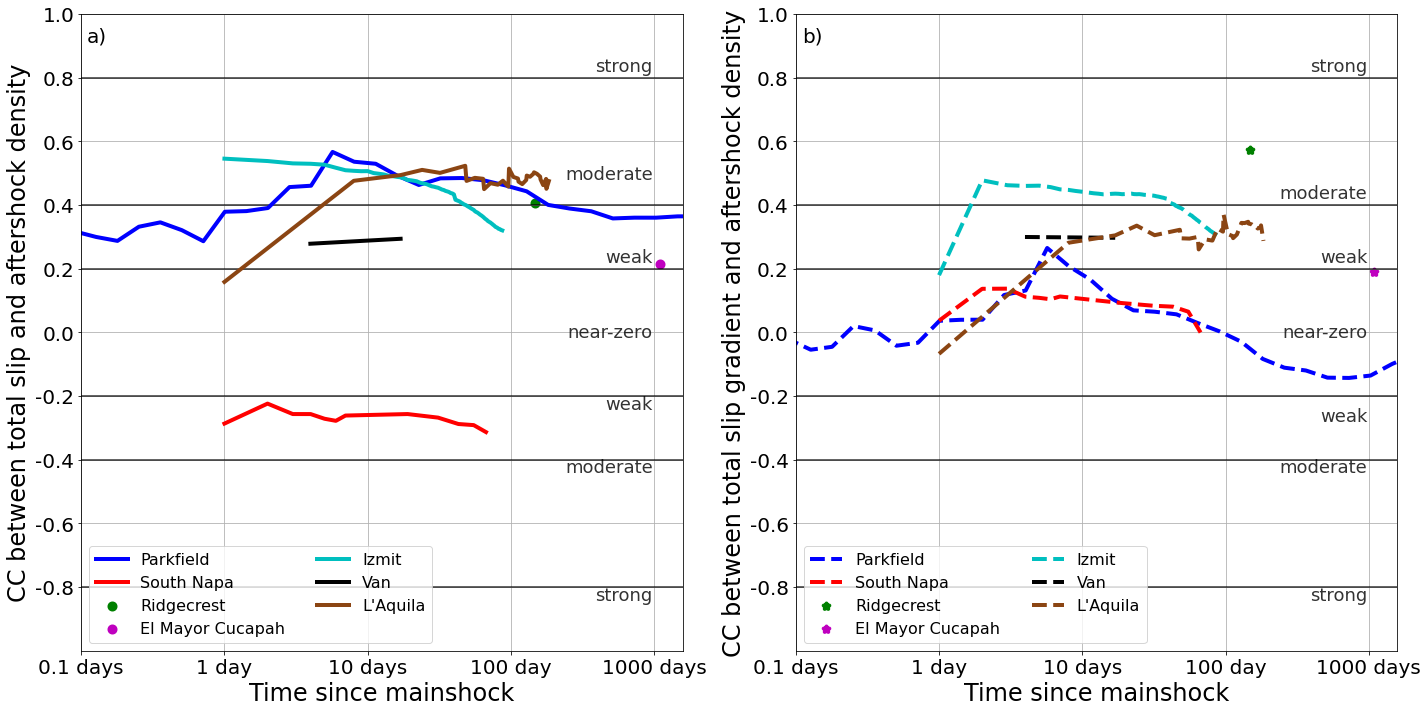

In [30]:
# Plots
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,2,1)
ax.plot([-1,3.2],[-0.8,-0.8],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[-0.4,-0.4],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[-0.2,-0.2],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.2,0.2],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.4,0.4],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.8,0.8],c = 'black',alpha = 0.8)
ax.text(2.99,0.82, 'strong', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.84, 'strong', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0.48, 'moderate', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.44, 'moderate', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0.22, 'weak', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.24, 'weak', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0, 'near-zero', fontsize = 18, alpha = 0.8,horizontalalignment='right',verticalalignment='center')

ax.plot(parklogdays,PARKCC,c = 'b',label = 'Parkfield', linewidth = 4) 
ax.plot(napalogdays,NAPACC,c = 'r',label = 'South Napa', linewidth = 4) 
ax.scatter(ridgelogdays,RIDGECC,c = 'g',label = 'Ridgecrest', linewidth = 4) 
ax.scatter(emclogdays,EMCCC,c = 'm',label = 'El Mayor Cucapah', linewidth = 4) 
ax.plot(izmitlogdays,IZMITCC,c = 'c',label = 'Izmit', linewidth = 4) 
ax.plot(vanlogdays,VANCC,c = 'black',label = 'Van', linewidth = 4) 
ax.plot(laqlogdays,LAQCC,c = 'saddlebrown',label = 'L\'Aquila', linewidth = 4) 
ax.set_ylim([-1,1])
ax.set_xlim([-1,3.2])
ax.set_yticks([-0.8,-0.6,-0.4,-0.2,-0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels(["-0.8","-0.6","-0.4","-0.2","0.0","0.2","0.4","0.6","0.8","1.0"],fontsize = 20)
ax.set_xticks([-1,0,1,2,3])
ax.set_xticklabels(['0.1 days','1 day','10 days','100 day','1000 days'],fontsize = 20)
ax.set_xlabel('Time since mainshock',fontsize = 24)
ax.set_ylabel('CC between total slip and aftershock density',fontsize = 24)
ax.grid()
ax.text(0.01,0.98, 'a)',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes, fontsize = 20)
ax.legend(loc = 'lower left',fontsize = 16,ncol = 2)

      
ax = fig.add_subplot(1,2,2)
ax.plot([-1,3.2],[-0.8,-0.8],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[-0.4,-0.4],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[-0.2,-0.2],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.2,0.2],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.4,0.4],c = 'black',alpha = 0.8)
ax.plot([-1,3.2],[0.8,0.8],c = 'black',alpha = 0.8)
ax.text(2.99,0.82, 'strong', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.84, 'strong', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0.42, 'moderate', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.44, 'moderate', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0.22, 'weak', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,-0.28, 'weak', fontsize = 18, alpha = 0.8,horizontalalignment='right')
ax.text(2.99,0, 'near-zero', fontsize = 18, alpha = 0.8,horizontalalignment='right',verticalalignment='center')

ax.plot(parklogdays,PARKGCC,c = 'b',label = 'Parkfield',linewidth = 4,linestyle = '--')
ax.plot(napalogdays,NAPAGCC,c = 'r',label = 'South Napa',linewidth = 4,linestyle = '--')
ax.scatter(ridgelogdays,RIDGEGCC,c = 'g',label = 'Ridgecrest',linewidth = 4,marker = '*') 
ax.scatter(emclogdays,EMCGCC,c = 'm',label = 'El Mayor Cucapah',linewidth = 4,marker = '*')
ax.plot(izmitlogdays,IZMITGCC,c = 'c',label = 'Izmit',linewidth = 4,linestyle = '--') 
ax.plot(vanlogdays,VANGCC,c = 'black',label = 'Van',linewidth = 4,linestyle = '--') 
ax.plot(laqlogdays,LAQGCC,c = 'saddlebrown',label = 'L\'Aquila',linewidth = 4,linestyle = '--') 
ax.set_ylim([-1,1])
ax.set_xlim([-1,3.2])
ax.set_yticks([-0.8,-0.6,-0.4,-0.2,-0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels(["-0.8","-0.6","-0.4","-0.2","0.0","0.2","0.4","0.6","0.8","1.0"],fontsize = 20)
ax.set_xticks([-1,0,1,2,3])
ax.set_xticklabels(['0.1 days','1 day','10 days','100 day','1000 days'],fontsize = 20)
ax.set_xlabel('Time since mainshock',fontsize = 24)
ax.set_ylabel('CC between total slip gradient and aftershock density',fontsize = 24)
ax.grid()
ax.text(0.01,0.98, 'b)',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes, fontsize = 20)
ax.legend(loc = 'lower left',fontsize = 16,ncol = 2)
plt.tight_layout()
fig.savefig('TOTALvAFTERSHOCK.pdf', dpi=300)